This notebook replaces all others, and is intended as the single source of truth for the de Berker et al., stroke paper.

In [61]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.colors import LogNorm
import eli5

import itertools
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget

from pprint import pprint
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


sns.set(style="ticks", color_codes=True)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.set_palette(sns.color_palette(flatui))
sns.__version__

'0.9.0'

In [112]:
np.random.seed(1234)

In [9]:
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=int(_xlabel_size*0.8))
    plt.yticks(tick_marks, classes, fontsize=int(_xlabel_size*0.8))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=_xlabel_size)
    plt.xlabel('Predicted label', fontsize=_ylabel_size)

## 1. Basic data analysis

In [10]:
order = ['Home', 'Comm. Hosp.', 'Inpatient', 'Death']

In [11]:
new_df = pd.read_excel('../data/Discharge destinations including Gender.xlsx', 
                   sheet_name='Gender',
                  header=1,
                   usecols=[0,1,2,3,5],
                  colnames=['Age', 'NIHSS', 'MRS', 'New Destination', 'Gender'])

In [12]:
new_df.head()
new_df.rename({'Unnamed: 3':'New Outcome'}, inplace=True, axis=1)

In [13]:
original_df =  pd.read_excel('../data/Discharge destinations 2.xlsx', 
                   sheet_name='Regression analysis',
                  header=2)
original_df.reset_index(inplace=True)
original_df.drop(['index', 'Key'], axis=1, inplace=True)
outcome_dict={0:'Death', 1:'Inpatient', 2:'CH', 3:'Home'}
original_df['Outcome']=original_df['Outcome'].map(lambda x: outcome_dict[x])

original_df.sort_values(by='Age', inplace=True)

In [14]:
combined_df = original_df.merge(new_df, on=['Age', 'NIHSS', 'MRS'])

In [15]:
combined_df.groupby('New Outcome')['Outcome'].value_counts()

New Outcome  Outcome  
D            Death        118
             Inpatient     10
             CH             2
H            Home         211
             CH            13
             Inpatient      7
T            Inpatient    604
             CH            46
             Death         10
             Home           7
TC           CH           398
             Inpatient     45
             Home          13
             Death          2
TCN          CH            23
             Inpatient      2
TN           Inpatient     49
             CH             1
Name: Outcome, dtype: int64

### Confusing because of identical people having different outcomes. 

Try and map according to what we think is correct, can we match everyboyd?

In [16]:
new_to_old_mapping = {'T': 'Inpatient',
          'TC': 'CH',
          'D': 'Death',
          'H': 'Home',
          'TN': 'Inpatient',
          'TCN': 'CH'}

In [17]:
new_df['Outcome'] = new_df['New Outcome'].map(new_to_old_mapping)

In [18]:
new_df['Outcome'].value_counts()

Inpatient    555
CH           299
Home         171
Death        106
Name: Outcome, dtype: int64

In [19]:
original_df['Outcome'].value_counts()

Inpatient    555
CH           299
Home         171
Death        106
Name: Outcome, dtype: int64

In [20]:
attempted_combine = original_df.merge(new_df, on=['Age', 'MRS', 'NIHSS', 'Outcome'])

In [21]:
attempted_combine.drop(['New Outcome'], axis=1, inplace=True)

# Set the combined df, with the gender column to the old df

In [22]:
df = attempted_combine.copy()

The pairplot shows all the differnet relationships in the data in one place.

Here we can see:

1. All groups are fairly similar in age, although in patient are perhaps on average slightly older and community hospital younger
2. Low NIHSS scores are associated with home or CH. Higher scores correspond to death.
3. Low MRS scores seem to be associated with Home, whilst high ones are associated with being an inpatient.

The scatter plots are a bit confusing, but it seems like MRS and age are positivel correlated. NIHSS and MRS are unclear.

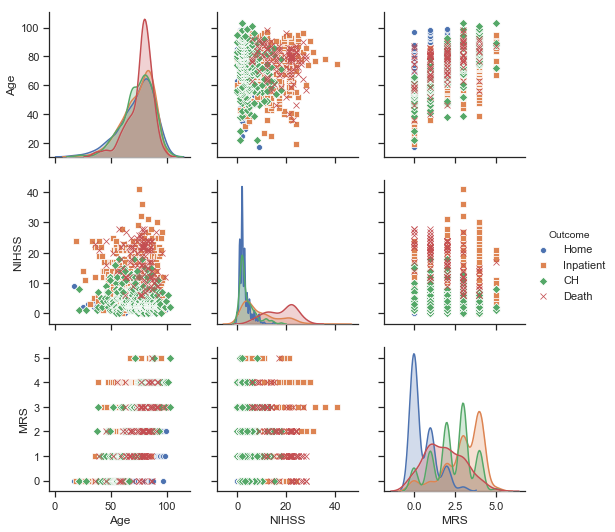

In [83]:
sns.pairplot(df, hue='Outcome', markers=["o", "s", "D", "x"])

## Digging into correlations between predictors

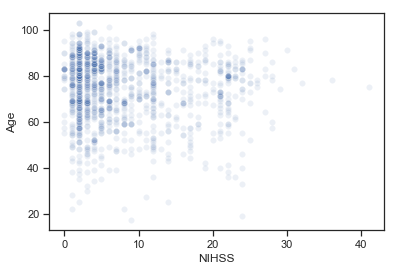

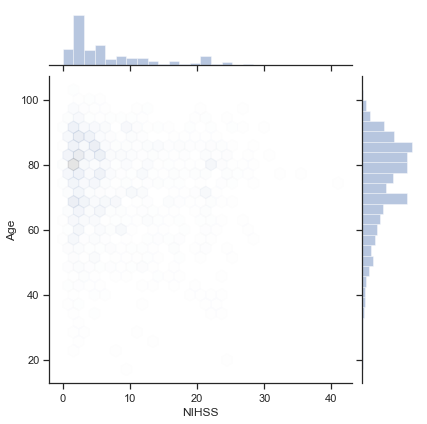

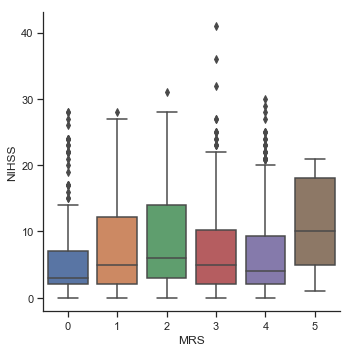

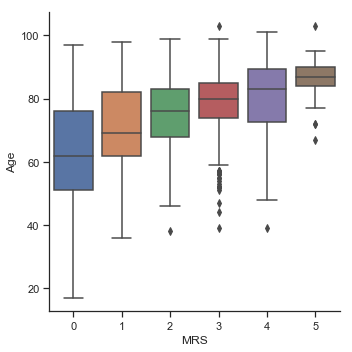

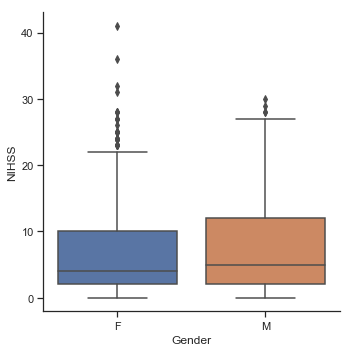

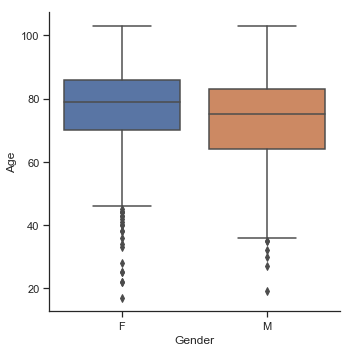

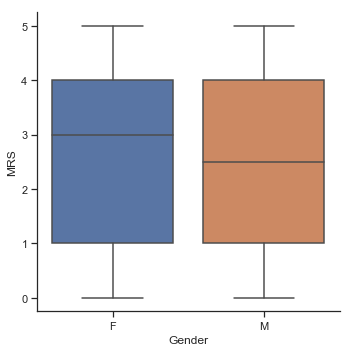

In [85]:
sns.scatterplot(x='NIHSS', y='Age', data=df, alpha=.1)
sns.jointplot(x='NIHSS', y='Age', data=df, alpha=.1, kind='hex')

sns.catplot(x="MRS", y="NIHSS", kind="box", data=df)
sns.catplot(x="MRS", y="Age", kind="box", data=df)

sns.catplot(x="Gender", y="NIHSS", kind="box", data=df)
sns.catplot(x="Gender", y="Age", kind="box", data=df)
sns.catplot(x="Gender", y="MRS", kind="box", data=df)

From this, it seems:
    
1. MRS and NIHSS are surprisingly unrelated
2. MRS is strongly related to age
3. NIHSS seems unrelated to age
4. Women are slightly older on avergae?

Indeed, this is supported by the raw correlations:

In [86]:
df.corr()

,Age,NIHSS,MRS
Age,1.000000,-0.068320,0.468291
NIHSS,-0.068320,1.000000,0.006326
MRS,0.468291,0.006326,1.000000


In [87]:
r, p = stats.pearsonr(df['Age'], df['MRS'])

In [88]:
p

2.2051103194744983e-77

# Figure 2

In [71]:
_xlabel_size = 15
_ylabel_size = 15

_plot_style = sns.axes_style()

_plot_style['axes.spines.right'] = False
_plot_style['axes.spines.top'] = False

f, axes = plt.subplots(1, 3, figsize=(full_figure_width, figure_height))
sns.set_style(_plot_style)


sns.catplot(x="MRS", y="NIHSS", kind="swarm", data=df, ax=axes[0], palette='Blues')
plt.sca(axes[0])
plt.xlabel("MRS",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()


sns.regplot(x="NIHSS", y="Age", data=df, ax=axes[1], line_kws={"color": "black"}, scatter_kws={'alpha':0.3})
plt.sca(axes[1])
plt.xlabel("Age",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()


sns.catplot(x="MRS", y="Age", kind="swarm", data=df, ax=axes[2], palette='Blues')
plt.sca(axes[2])
plt.xlabel("MRS",fontsize=_xlabel_size)
plt.ylabel('Age', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

plt.show()

with open('figures/fig2.png', 'wb') as fileout:
    f.savefig(fileout, bbox_inches='tight')



NameError: name 'full_figure_width' is not defined

## Separating predictors by group

### NIHSS

NIHSS seems to have clear signal. Higher NIHSS scores are bad news.

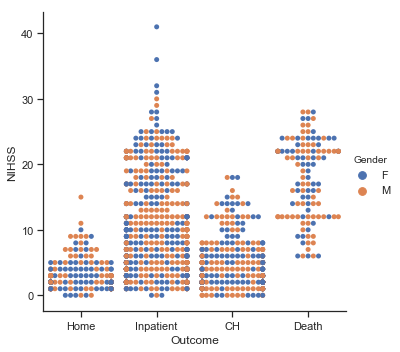

In [89]:
sns.catplot(x="Outcome", y="NIHSS", hue='Gender', kind="swarm", data=df)
plt.show()

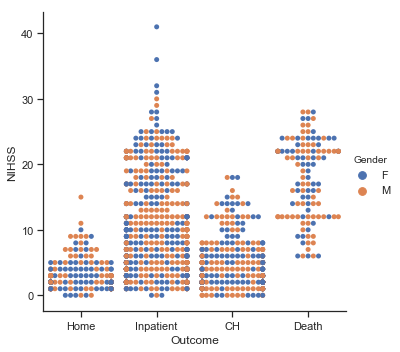

In [90]:
sns.catplot(x="Outcome", y="NIHSS", kind="swarm", hue='Gender', data=df)
plt.show()

### MRS

Home is associated with **lower** MRS scores.

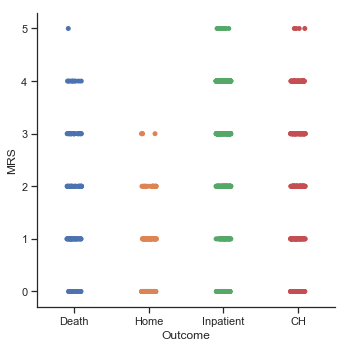

In [13]:
sns.catplot(x="Outcome", y="MRS", data=df, jitter=1)

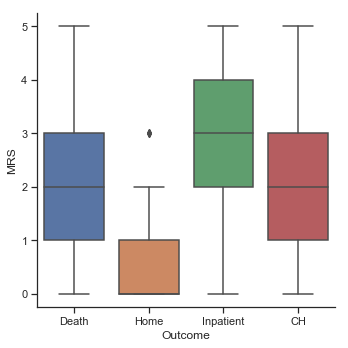

In [14]:
sns.catplot(x="Outcome", y="MRS", kind="box", data=df)

Makes more sense to look at MRS as a categorical variable.

In [15]:
dbl_count = df.groupby(['MRS', 'Outcome'])['Age'].count()
dbl_count

MRS  Outcome  
0    CH            37
     Death         13
     Home         100
     Inpatient     37
1    CH            48
     Death         31
     Home          46
     Inpatient     33
2    CH            82
     Death         28
     Home          21
     Inpatient     92
3    CH            83
     Death         24
     Home           4
     Inpatient    165
4    CH            45
     Death          9
     Inpatient    216
5    CH             4
     Death          1
     Inpatient     12
Name: Age, dtype: int64

### Age

Age does not seem particularly related, although young people are rarely sent home after stroke:

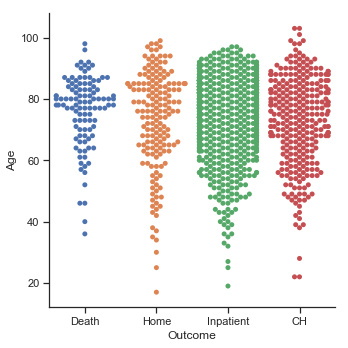

In [16]:
sns.catplot(x="Outcome", y="Age", kind="swarm", data=df)

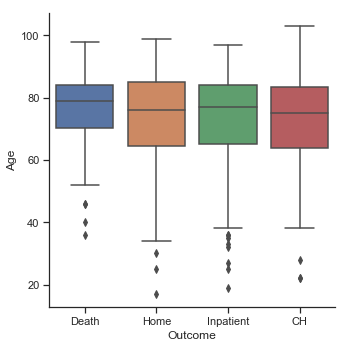

In [17]:
sns.catplot(x="Outcome", y="Age", kind="box", data=df)

# Figure 1

In [248]:
!pip install ptitprince==0.1.3

    100% |████████████████████████████████| 61kB 1.5MB/s 
    100% |████████████████████████████████| 2.9MB 221kB/s 
  Running setup.py bdist_wheel for ptitprince ... done
  Stored in directory: /Users/archy/Library/Caches/pip/wheels/f6/49/22/ec1978d22625f6f24e8875510b35ee0c40000c384dcb3ae236
Successfully built ptitprince
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
full_figure_width = 18
figure_height = 8
_xlabel_size = 15
_ylabel_size = 15



In [98]:
df.groupby('Gender')['Outcome'].value_counts()

Gender  Outcome  
F       Inpatient    290
        CH           223
        Home         110
        Death         50
M       Inpatient    363
        CH           198
        Home         101
        Death         68
Name: Outcome, dtype: int64

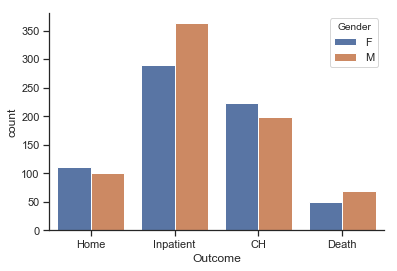

In [100]:
sns.countplot(x='Outcome', data=df, hue='Gender')

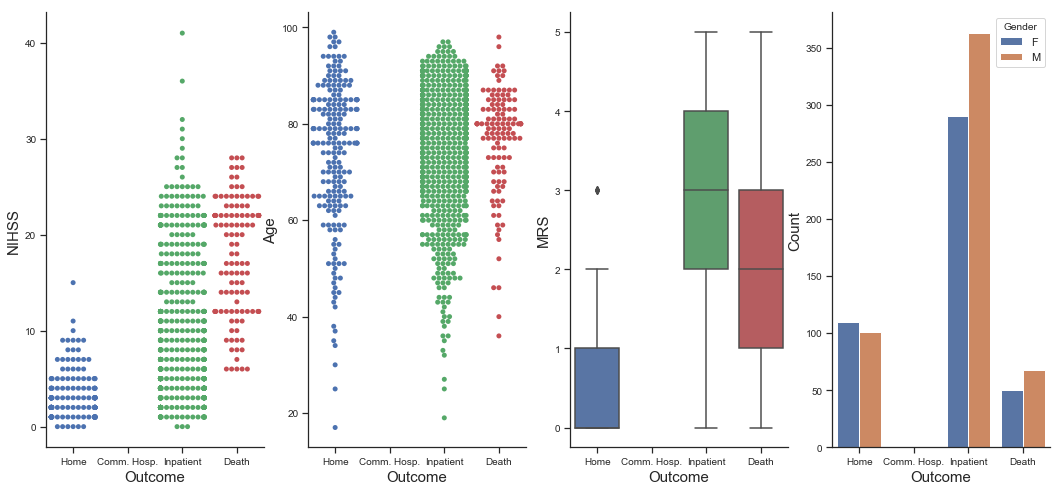

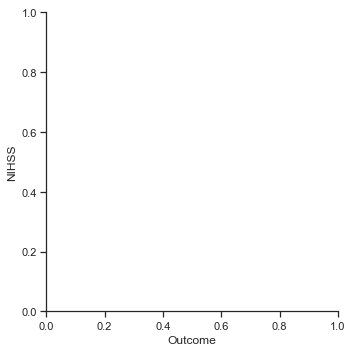

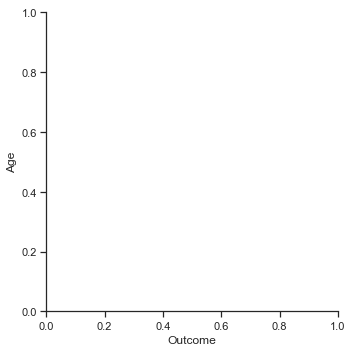

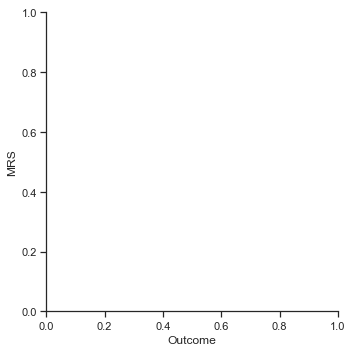

In [102]:

_plot_style = sns.axes_style()

_plot_style['axes.spines.right'] = False
_plot_style['axes.spines.top'] = False

f, axes = plt.subplots(1, 4, figsize=(full_figure_width, figure_height))
sns.set_style(_plot_style)


cp1 = sns.catplot(x="Outcome", y="NIHSS", kind="swarm", data=df, ax=axes[0], order=order)
plt.sca(axes[0])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('NIHSS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

sns.catplot(x="Outcome", y="Age", kind="swarm", data=df, ax=axes[1], order=order)
plt.sca(axes[1])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('Age', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

sns.catplot(x="Outcome", y="MRS", kind="box", data=df, ax=axes[2], order=order)
plt.sca(axes[2])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('MRS', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

sns.countplot(x='Outcome', data=df, hue='Gender',ax=axes[3], order=order)
plt.sca(axes[3])
plt.xlabel("Outcome",fontsize=_xlabel_size)
plt.ylabel('Count', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

plt.show()

with open('figures/fig1.png', 'wb') as fileout:
    f.savefig(fileout, bbox_inches='tight')


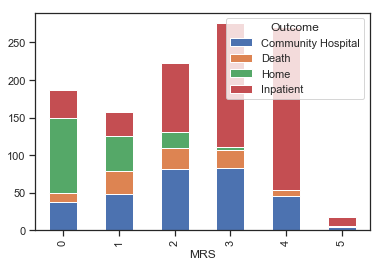

In [272]:
df_plot = df.groupby(['MRS', 'Outcome']).size().reset_index().pivot(columns='Outcome', index='MRS', values=0).plot(kind='bar', stacked=True)

In [291]:
countby_MRS = df.groupby(['MRS', 'Outcome'])['MRS'].count().unstack(fill_value=0).stack()

In [297]:
countby_MRS

MRS  Outcome           
0    Community Hospital     37
     Death                  13
     Home                  100
     Inpatient              37
1    Community Hospital     48
     Death                  31
     Home                   46
     Inpatient              33
2    Community Hospital     82
     Death                  28
     Home                   21
     Inpatient              92
3    Community Hospital     83
     Death                  24
     Home                    4
     Inpatient             165
4    Community Hospital     45
     Death                   9
     Home                    0
     Inpatient             216
5    Community Hospital      4
     Death                   1
     Home                    0
     Inpatient              12
dtype: int64

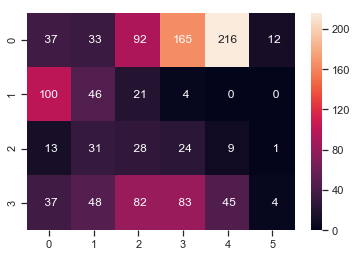

In [311]:
sns.heatmap(np.flip(countby_MRS.values.reshape(6, 4).T, axis=0), 
            annot=True, fmt='3g')

ValueError: could not convert string to float: 'Community Hospital'

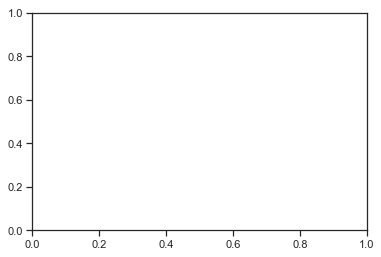

In [317]:
sns.kdeplot(data=df)

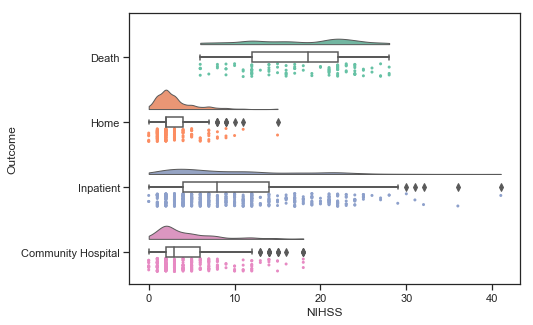

In [260]:
import ptitprince as pt
dx = "Outcome"; dy = "NIHSS"; ort = "h"; pal = "Set2"; sigma = .2
ax=pt.RainCloud(x = dx, y = dy, data = df, palette = pal, bw = sigma,
                 width_viol = .6, figsize = (7,5), orient = ort, move = .2)

## 2. Univariate stats


ANOVAs/KW confirm that MRS and NIHSS both have signal about destination, whereas age alone does not.

In [24]:
def compute_kruskal(df, factor):
    F, p = stats.kruskal(df.loc[df['Outcome']=='Home',factor], 
                      df.loc[df['Outcome']=='Death',factor], 
                      df.loc[df['Outcome']=='CH',factor], 
                      df.loc[df['Outcome']=='Inpatient',factor]) 
    return F, p

def compute_pairwise_p(df, factor):
    outcomes = df.Outcome.unique()
    p_mtx = np.zeros((len(outcomes), len(outcomes))) 
    for i, o1 in enumerate(outcomes):
        for j, o2 in enumerate(outcomes):
             _ , p_mtx[i, j]= stats.ttest_ind(df.loc[df['Outcome']==o1, factor],
               df.loc[df['Outcome']==o2, factor])
            
    return p_mtx, outcomes
         
def univariate_stats(df, factor):
    F, p = compute_kruskal(df, factor)
    
    print(f"{factor}, p={p} from Kruskal Wallace")
    p_MRS, outcomes = compute_pairwise_p(df, factor)
    mask = np.zeros_like(p_MRS)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(p_MRS, xticklabels=outcomes, yticklabels=outcomes, mask=mask, annot=True, linewidths=.5)
    
    plt.title(factor)
    plt.show()
    

### MRS

MRS, p=7.082648019869189e-106 from Kruskal Wallace


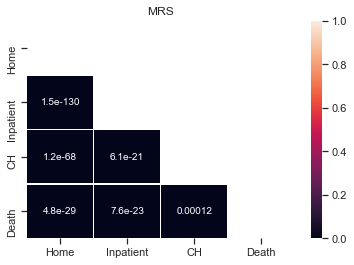

In [25]:
univariate_stats(df, "MRS")

### NIHSS

NIHSS, p=7.095358869720286e-106 from Kruskal Wallace


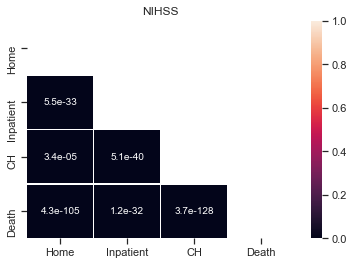

In [26]:
univariate_stats(df, "NIHSS")

### Age

Age, p=0.5292439565704465 from Kruskal Wallace


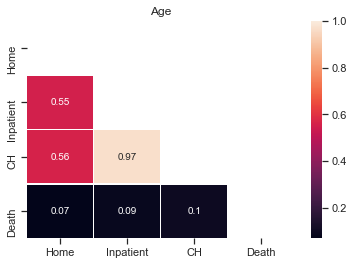

In [27]:
univariate_stats(df, "Age")


This implies that the age of people who die after stroke may be slightly different from each of the other outcomes, but that the other outcomes do not differ between themselves.

# Gender

Gender, p=0.014972126208528063 from Kruskal Wallace


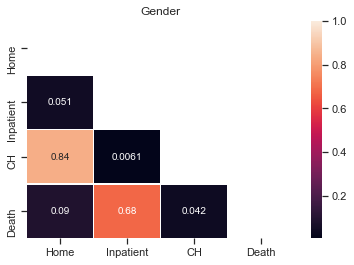

In [28]:
mapped_gender_df =df.copy()
mapped_gender_df['Gender']=  mapped_gender_df['Gender'].map({'M':0, 'F':1})
univariate_stats(mapped_gender_df, "Gender")

There seems to be a very sall amount of signal here. Is this the right test to do? Seems a bit weird as they're both categorical. Chi 2 makes more sense.

In [29]:
from scipy.stats import chi2_contingency, binom_test

In [30]:
x2_gender_outcome = df.groupby('Outcome')['Gender'].value_counts().sort_index()
x2_gender_outcome

Outcome    Gender
CH         F         223
           M         198
Death      F          50
           M          68
Home       F         110
           M         101
Inpatient  F         290
           M         363
Name: Gender, dtype: int64

In [31]:
x2_gender_outcome_np = x2_gender_outcome.values.reshape(4,-1)
x2_gender_outcome_np

array([[223, 198],
       [ 50,  68],
       [110, 101],
       [290, 363]])

In [32]:
_, p,_, expected = chi2_contingency(x2_gender_outcome_np)
p

0.014920844788824512

There's a small effect, but as always with X2, difficult to say where it comes from!

In [33]:
expected - x2_gender_outcome_np

array([[-21.05203136,  21.05203136],
       [  6.60299359,  -6.60299359],
       [ -8.78617249,   8.78617249],
       [ 23.23521026, -23.23521026]])

We can use a binomial test to check whether the probability of a patient being female diverges from 0.5 for each outcome:

In [34]:
x2_gender_outcome['CH','F']

223

In [35]:
x2_gender_outcome['CH','M']

198

In [37]:
def binomial_test_gender(df, outcome):
    # Female = 1, Male = 0    
    base_rate_gender= df['Gender'].value_counts()['F'] / (len(df))
    female_rate_outcome = df.loc[df['Outcome']==outcome, 'Gender'].value_counts()['F'] 
    observations = sum(df['Outcome']==outcome)
    
    p_binom = binom_test(female_rate_outcome, observations, base_rate_gender)
    return p_binom

In [41]:
for outcome in df['Outcome'].unique():
    p_binom = binomial_test_gender(df, outcome)
    print(f"{outcome}, binomial for Gender p={p_binom}")



Home, binomial for Gender p=0.24159405844265475
Inpatient, binomial for Gender p=0.07158591546591128
CH, binomial for Gender p=0.040567950491560034
Death, binomial for Gender p=0.23219264952619983


In [145]:
base_rate_gender['M']

M    809
F    752
Name: Gender, dtype: int64

# 3. Splitting analysis by MRS level 

We are going to analyse the relationship between age, NIHSS, and outcome independently for each level of the MRS. For a reminder, these are what the levels are described as:

- 0 - No symptoms.
- 1 - No significant disability. Able to carry out all usual activities, despite some symptoms.
- 2 - Slight disability. Able to look after own affairs without assistance, but unable to carry out all previous activities.
- 3 - Moderate disability. Requires some help, but able to walk unassisted.
- 4 - Moderately severe disability. Unable to attend to own bodily needs without assistance, and unable to walk unassisted.
- 5 - Severe disability. Requires constant nursing care and attention, bedridden, incontinent.
- 6 - Dead.

#### Does the relationship between Age and NIHSS differ for each level of MRS?

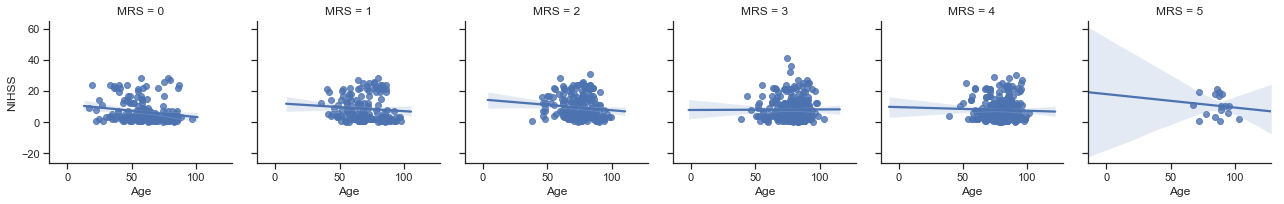

In [22]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.regplot, "Age", 'NIHSS')
plt.show()


#### Does the relationship between Age and Outcome differ for each level of MRS?

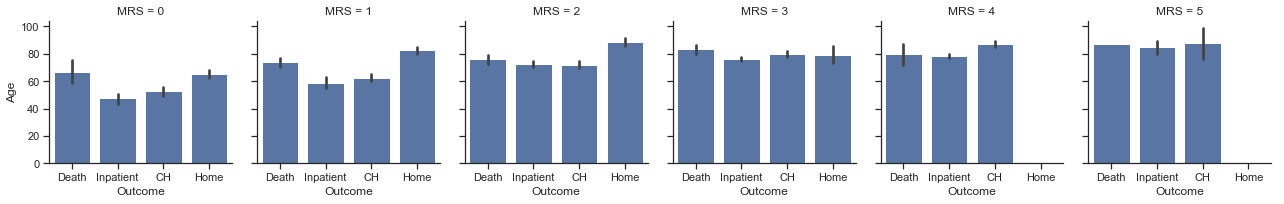

In [23]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.barplot, "Outcome", 'Age', order=['Death', 'Inpatient','CH', 'Home'])
plt.show()

Quite subtle. So the average age of somebody who dies with an MRS score of 0 is notably higher than that of somebody who ends up as an inpatient with MRS score of 0. This could be seen as a statement about volatility. 

As you increase the MRS score, age differences seem to flatten out.

#### Does the relationship between NIHSS and Outcome differ for each level of MRS?

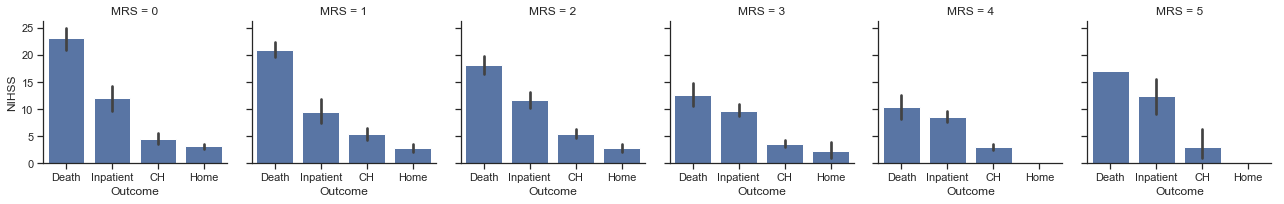

In [24]:
g = sns.FacetGrid(df, col="MRS")
g.map(sns.barplot, "Outcome", 'NIHSS', order=['Death', 'Inpatient','CH', 'Home'])
plt.show()

Having a high NIHSS score is clearly bad news regardless of your MRS rating. NIHSS appears to be informative of outcome for every level of the MRS, demonstrating that the two carry different types of information.

## Visualizing correlations for each outcome

# Figure 2b

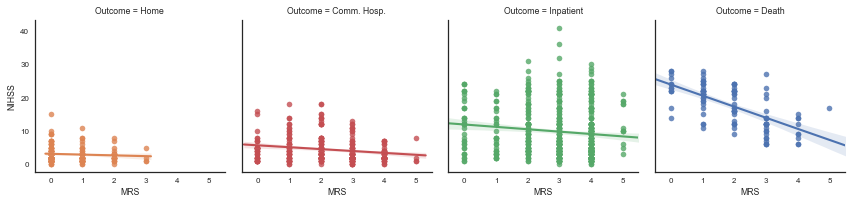

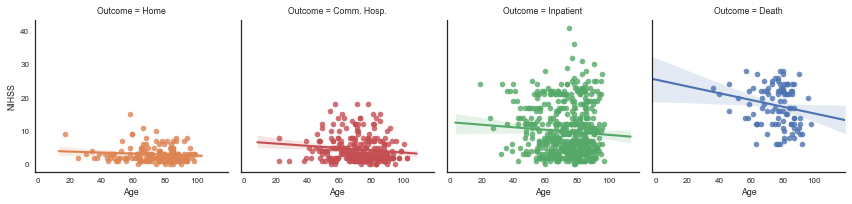

In [425]:

g = sns.FacetGrid(df, col="Outcome", hue="Outcome", col_order=order)
r_plots = g.map(sns.regplot, "MRS", 'NIHSS')

for ax in r_plots.axes[:,0]:
    ax.set_xlim((-.5, 5.5))

with open('figures/fig2bi.png', 'wb') as fileout:
    g.fig.savefig(fileout, bbox_inches='tight')
    
g = sns.FacetGrid(df, col="Outcome", hue="Outcome", col_order=order)
r_plots = g.map(sns.regplot, "Age", 'NIHSS')

with open('figures/fig2bii.png', 'wb') as fileout:
    g.fig.savefig(fileout, bbox_inches='tight')



Indeed, for death NIHSS and MRS are negatively correlated:

In [694]:
r = df[df['Outcome']=='Death'].corr()
r, p = stats.pearsonr(df.loc[df['Outcome']=='Death','MRS'].values,
               df.loc[df['Outcome']=='Death','NIHSS'].values)
print(r, p)

-0.6513546918855714 4.025539700422566e-14


In [693]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Inpatient','MRS'].values,
               df.loc[df['Outcome']=='Inpatient','NIHSS'].values)
print(r, p)

-0.11772110955440918 0.005490817068340396


In [692]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Comm. Hosp.','MRS'].values,
               df.loc[df['Outcome']=='Comm. Hosp.','NIHSS'].values)
print(r, p)

-0.19628141649209627 0.0006423629769708296


In [695]:
r, p = stats.pearsonr(df.loc[df['Outcome']=='Home','MRS'].values,
               df.loc[df['Outcome']=='Home','NIHSS'].values)
print(r, p)

-0.0812032166245912 0.29104766234067003


Marginal for age, won't survive multiple comparisons

In [439]:
r = df[df['Outcome']=='Death'].corr()
r, p = stats.pearsonr(df.loc[df['Outcome']=='Death','Age'].values,
               df.loc[df['Outcome']=='Death','NIHSS'].values)
print(p)

0.048558478140595114


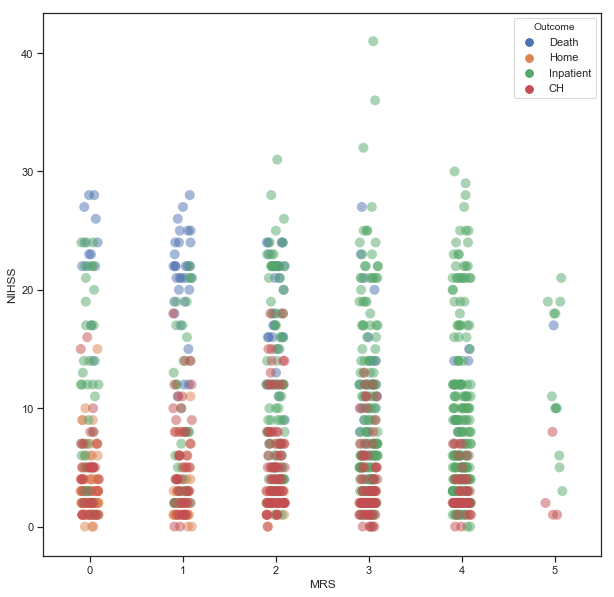

In [26]:
plt.figure(figsize=(10,10))
sns.stripplot(x='MRS', y='NIHSS', hue='Outcome', data=df, alpha=.5, size=10)

# 4. Building simple predictive models

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.dummy import DummyClassifier

In [28]:
lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')

# Split the data, with stratified sampling

In [47]:
def stratified_sample_df(df, col, frac, random_state=1234):
    if frac > 1.:
        raise ValueError
        
    original_numbers = df[col].value_counts()
    sample_n = {k: int(v * frac) for k, v in original_numbers.items()}

    df_ = df.groupby(col).apply(lambda x: x.sample(sample_n[x.name], random_state=random_state))
    df_.index = df_.index.droplevel(0)

    return df_

In [48]:
train_frac = 0.9
test_frac = 0.1

In [49]:
df_train = stratified_sample_df(df, col='Outcome', frac=train_frac, random_state=1234)

In [50]:
df_test = df.loc[df.index.difference(df_train.index)]

Confirm that both train and test have a similar distribution over classes:

Text(0.5, 1.0, 'Train')

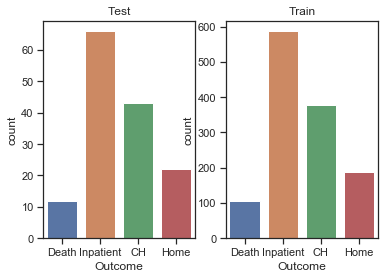

In [51]:
plt.subplot(121)
sns.countplot(x='Outcome', data=df_test, order=['Death', 'Inpatient', 'CH', 'Home'])
plt.title('Test')
plt.subplot(122)
sns.countplot(x='Outcome', data=df_train, order=['Death', 'Inpatient', 'CH', 'Home'])
plt.title('Train')

## Dummy model

Reminder of the class imbalance

In [52]:
df_train['Outcome'].value_counts()

Inpatient    587
CH           378
Home         189
Death        106
Name: Outcome, dtype: int64

In [53]:
dm = DummyClassifier(strategy='prior')

In [54]:
X = pd.get_dummies(df_train['MRS'])
y = df_train['Outcome'].map({v:k for k,v in outcome_dict.items()}).values

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00109076, 0.00091815, 0.00129008, 0.00153017, 0.00105596,
       0.00085974, 0.000844  , 0.00138187, 0.00114202, 0.00085211]),
 'score_time': array([0.04829836, 0.00102186, 0.00132394, 0.00107098, 0.00093007,
       0.00084829, 0.00134897, 0.00115609, 0.00215983, 0.00083399]),
 'test_accuracy': array([0.46456693, 0.46456693, 0.46456693, 0.46456693, 0.46456693,
       0.46456693, 0.46825397, 0.464     , 0.46774194, 0.47154472]),
 'test_f1_macro': array([0.15860215, 0.15860215, 0.15860215, 0.15860215, 0.15860215,
       0.15860215, 0.15945946, 0.15846995, 0.15934066, 0.16022099]),
 'train_accuracy': array([0.46601942, 0.46601942, 0.46601942, 0.46601942, 0.46601942,
       0.46601942, 0.46560847, 0.4660793 , 0.46566901, 0.46525945]),
 'train_f1_macro': array([0.1589404 , 0.1589404 , 0.1589404 , 0.1589404 , 0.1589404 ,
       0.1589404 , 0.15884477, 0.15895433, 0.15885886, 0.15876351])}


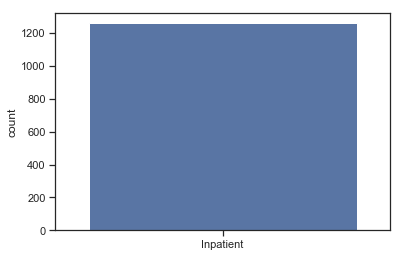

In [55]:
pprint(cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro'), cv=10))
y_pred = cross_val_predict(dm, X, y, cv=5)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

## MRS

In [38]:
X = pd.get_dummies(df_train['MRS']).values

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.01918006, 0.01557207, 0.01382017, 0.02076912, 0.0137248 ]),
 'score_time': array([0.00206113, 0.00288391, 0.00185299, 0.00251102, 0.0024929 ]),
 'test_accuracy': array([0.51470588, 0.56372549, 0.51470588, 0.44334975, 0.55721393]),
 'test_f1_macro': array([0.40556042, 0.41415249, 0.36785293, 0.33597445, 0.39677406]),
 'test_f1_micro': array([0.51470588, 0.56372549, 0.51470588, 0.44334975, 0.55721393]),
 'train_accuracy': array([0.53817734, 0.54802956, 0.50123153, 0.49692497, 0.54969325]),
 'train_f1_macro': array([0.45601102, 0.39269067, 0.36084953, 0.38177633, 0.39719197]),
 'train_f1_micro': array([0.53817734, 0.54802956, 0.50123153, 0.49692497, 0.54969325])}


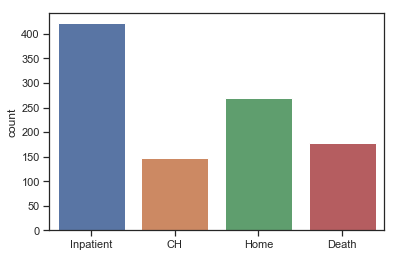

In [39]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

## NIHSS

A simple logistic regression works poorly:

In [40]:
lm = LogisticRegression(multi_class='multinomial', solver='saga')

In [41]:
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
X

array([[-0.29608723],
       [-0.85009206],
       [-0.15758602],
       ...,
       [-0.57308964],
       [ 1.78143089],
       [ 0.1194164 ]])

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00583315, 0.00506496, 0.00478983, 0.00444174, 0.00761199]),
 'score_time': array([0.00268984, 0.00206494, 0.00168014, 0.00196314, 0.00329304]),
 'test_accuracy': array([0.51470588, 0.5245098 , 0.5245098 , 0.51231527, 0.49751244]),
 'test_f1_macro': array([0.27823465, 0.28069627, 0.29500726, 0.30090822, 0.2693649 ]),
 'test_f1_micro': array([0.51470588, 0.5245098 , 0.5245098 , 0.51231527, 0.49751244]),
 'train_accuracy': array([0.51847291, 0.52093596, 0.52093596, 0.52644526, 0.52515337]),
 'train_f1_macro': array([0.29350308, 0.28265319, 0.30217918, 0.30611857, 0.324227  ]),
 'train_f1_micro': array([0.51847291, 0.52093596, 0.52093596, 0.52644526, 0.52515337])}


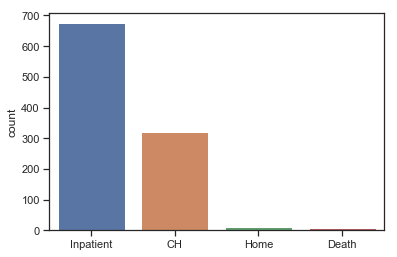

In [42]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

#### Try using NIHSS as categorical variable

In [43]:
X = pd.get_dummies(df_train['NIHSS'])

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.02891016, 0.031636  , 0.03334284, 0.02692509, 0.0330162 ]),
 'score_time': array([0.00388098, 0.00341606, 0.00337887, 0.00315499, 0.00320578]),
 'test_accuracy': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'test_f1_macro': array([0.30664179, 0.27167565, 0.2841199 , 0.30250784, 0.24829109]),
 'test_f1_micro': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'train_accuracy': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ]),
 'train_f1_macro': array([0.28337938, 0.27321048, 0.34900101, 0.34470283, 0.29794174]),
 'train_f1_micro': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ])}


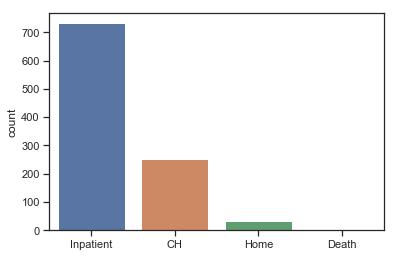

In [44]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y, cv=5)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

What do the parameters actually look like in this model?

In [45]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5, return_estimator=True)

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

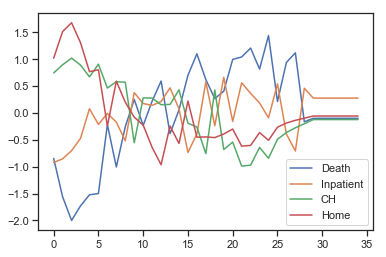

In [46]:
est = scores['estimator'][0]
plt.plot(est.coef_.T)
plt.legend(list(outcome_dict.values()))

Are we regularizating too much?

In [47]:
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

In [48]:
pprint(scores)

{'fit_time': array([0.02978206, 0.03093791, 0.02950501, 0.02930307, 0.02931595]),
 'score_time': array([0.00436616, 0.00489712, 0.00290275, 0.00270081, 0.00303388]),
 'test_accuracy': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'test_f1_macro': array([0.30664179, 0.27167565, 0.2841199 , 0.30250784, 0.24829109]),
 'test_f1_micro': array([0.53921569, 0.52941176, 0.50980392, 0.50246305, 0.49751244]),
 'train_accuracy': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ]),
 'train_f1_macro': array([0.28337938, 0.27321048, 0.34900101, 0.34470283, 0.29794174]),
 'train_f1_micro': array([0.52955665, 0.52955665, 0.53571429, 0.53259533, 0.5398773 ])}


Confusion matrix, without normalization
[[  1  94   0   0]
 [  1 418  72   8]
 [  0 155  98  16]
 [  0  65  81   7]]


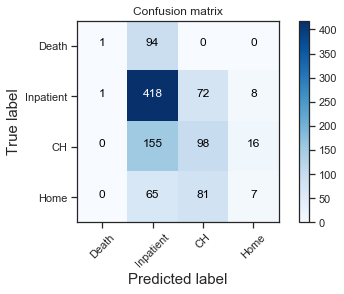

In [49]:
plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

#### What is the effect of balancing the classes?

{'fit_time': array([0.00628495, 0.00431299, 0.00585508, 0.00520921, 0.00653696]),
 'score_time': array([0.00217199, 0.001472  , 0.00149989, 0.00146699, 0.00179982]),
 'test_accuracy': array([0.35784314, 0.40196078, 0.37745098, 0.33004926, 0.40298507]),
 'test_f1_macro': array([0.36389507, 0.40602662, 0.38029093, 0.32499734, 0.40254386]),
 'test_f1_micro': array([0.35784314, 0.40196078, 0.37745098, 0.33004926, 0.40298507]),
 'train_accuracy': array([0.37807882, 0.36699507, 0.37315271, 0.38499385, 0.36687117]),
 'train_f1_macro': array([0.37829947, 0.36801644, 0.37425016, 0.38813373, 0.36871771]),
 'train_f1_micro': array([0.37807882, 0.36699507, 0.37315271, 0.38499385, 0.36687117])}


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


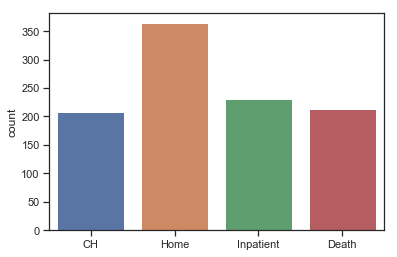

Confusion matrix, without normalization
[[ 65  26   4   0]
 [136 140 116 107]
 [ 12  51  62 144]
 [  1  14  25 113]]


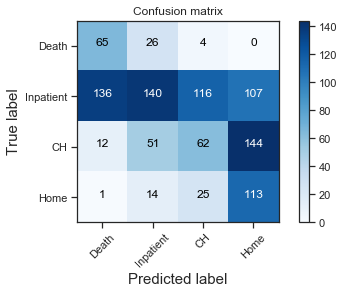

In [50]:
lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

The confusion matrices look much better if you balance, but the raw accuracy is poorer - the test accuracy is *worse* than the dummy classifier

## Age

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

{'fit_time': array([0.00679016, 0.00561404, 0.00522685, 0.00544381, 0.00765681]),
 'score_time': array([0.0026319 , 0.00210214, 0.00230622, 0.00190616, 0.00301909]),
 'test_accuracy': array([0.49019608, 0.49019608, 0.49019608, 0.49261084, 0.49253731]),
 'test_f1_macro': array([0.16447368, 0.16447368, 0.16447368, 0.1650165 , 0.165     ]),
 'test_f1_micro': array([0.49019608, 0.49019608, 0.49019608, 0.49261084, 0.49253731]),
 'train_accuracy': array([0.49137931, 0.49137931, 0.49137931, 0.49077491, 0.49079755]),
 'train_f1_macro': array([0.16473988, 0.16473988, 0.16473988, 0.16460396, 0.16460905]),
 'train_f1_micro': array([0.49137931, 0.49137931, 0.49137931, 0.49077491, 0.49079755])}


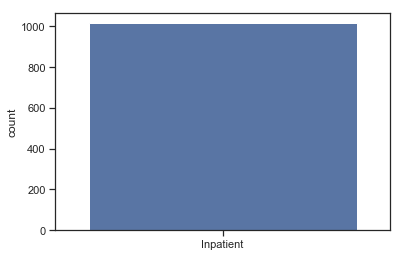

Confusion matrix, without normalization
[[  0  95   0   0]
 [  0 499   0   0]
 [  0 269   0   0]
 [  0 153   0   0]]


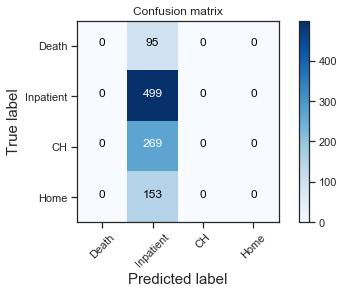

In [51]:
lm = LogisticRegression(multi_class='multinomial', solver='saga')
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
pprint(scores)
y_pred = cross_val_predict(lm, X, y)
sns.countplot([outcome_dict[yy] for yy in y_pred])
plt.show()

plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())

Basically no signal in age - it collapses to predicting the majority class

So to round up, if we don't try and balance the classes, we get something like this:

In [62]:
best_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)

In [95]:
CROSS_VAL=10
collated_scores = {}

dm = DummyClassifier(strategy='prior')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['dummy'] = scores['test_accuracy']

X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['MRS'] = scores['test_accuracy']

X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['NIHSS'] = scores['test_accuracy']


X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['Age'] = scores['test_accuracy']

X = pd.get_dummies(df_train['Gender'])
scores = cross_validate(best_rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
collated_scores['Gender'] = scores['test_accuracy']


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


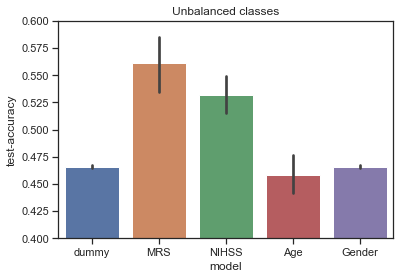

In [96]:
flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[['Age', 'MRS', 'dummy', 'NIHSS', 'Gender']].max(), axis=1)

performance = performance[['model', 'test-accuracy']]
sns.barplot(x='model', y='test-accuracy', data=performance)
plt.title('Unbalanced classes')
plt.ylim((0.4, 0.6))
plt.show()

And if we do:

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted 

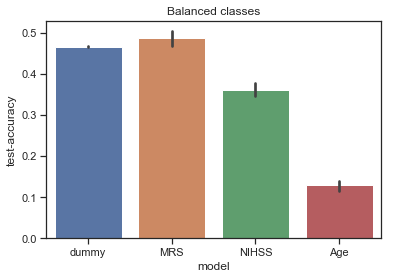

In [97]:
collated_scores = {}

dm = DummyClassifier(strategy='prior')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(dm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['dummy'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = pd.get_dummies(df_train['MRS'])
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['MRS'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['NIHSS'] = scores['test_accuracy']

lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight='balanced')
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
scores = cross_validate(lm, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=5)
collated_scores['Age'] = scores['test_accuracy']


flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[['Age', 'MRS', 'dummy', 'NIHSS']].max(), axis=1)

performance = performance[['model', 'test-accuracy']]
sns.barplot(x='model', y='test-accuracy', data=performance)
plt.title('Balanced classes')
plt.show()

### Using pairs 

In [98]:
def run_model(X, class_weight=None, rf=None):
    if rf is None:
        rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)
        
    scores = cross_validate(rf, X, y, scoring=('accuracy', 'f1_macro', 'f1_micro'), cv=CROSS_VAL)
    # collated_scores['NIHSS'] = scores['test_accuracy']
    pprint(scores)
    y_pred = cross_val_predict(rf, X, y)
    sns.countplot([outcome_dict[yy] for yy in y_pred])
    plt.show()

    plot_confusion_matrix(confusion_matrix(y, y_pred), classes=outcome_dict.values())
    return scores

### Age and NIHSS

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


{'fit_time': array([0.21274805, 0.24873877, 0.24966311, 0.23334599, 0.1848042 ,
       0.16547513, 0.14882874, 0.1199019 , 0.13649297, 0.12431502]),
 'score_time': array([0.04570484, 0.06441021, 0.06510687, 0.03198981, 0.06113982,
       0.04009891, 0.02971816, 0.03041887, 0.038975  , 0.03050494]),
 'test_accuracy': array([0.61417323, 0.56692913, 0.5984252 , 0.61417323, 0.62992126,
       0.5511811 , 0.50793651, 0.592     , 0.57258065, 0.58536585]),
 'test_f1_macro': array([0.5131203 , 0.44667387, 0.51110713, 0.45950567, 0.49445252,
       0.37300151, 0.35382975, 0.51115644, 0.40276142, 0.42829992]),
 'test_f1_micro': array([0.61417323, 0.56692913, 0.5984252 , 0.61417323, 0.62992126,
       0.5511811 , 0.50793651, 0.592     , 0.57258065, 0.58536585]),
 'train_accuracy': array([0.66107679, 0.66990291, 0.66725508, 0.66813769, 0.64960282,
       0.66725508, 0.6675485 , 0.67312775, 0.66021127, 0.6701847 ]),
 'train_f1_macro': array([0.53271587, 0.56590107, 0.56870799, 0.56505025, 0.5494401

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


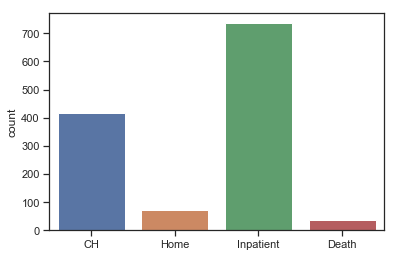

Confusion matrix, without normalization
[[ 20  85   1   0]
 [ 15 453 101  18]
 [  0 136 222  20]
 [  0  62  93  34]]


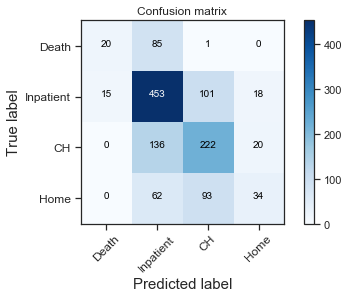

In [99]:
X = df_train[['Age', 'NIHSS']].values.reshape(-1,2)
X = stats.zscore(X)
scores = run_model(X)
collated_scores['Age + NIHSS'] = scores['test_accuracy']

### Age and MRS

{'fit_time': array([0.12448692, 0.11045504, 0.29427004, 0.33299685, 0.186975  ,
       0.13978386, 0.2244432 , 0.22421098, 0.17133594, 0.20816374]),
 'score_time': array([0.02713132, 0.02698803, 0.04494309, 0.08368921, 0.03237081,
       0.0336833 , 0.03627181, 0.05617094, 0.03271294, 0.03702116]),
 'test_accuracy': array([0.53543307, 0.62992126, 0.62992126, 0.65354331, 0.5984252 ,
       0.59055118, 0.66666667, 0.728     , 0.62903226, 0.60162602]),
 'test_f1_macro': array([0.42928234, 0.58415711, 0.5850065 , 0.53975469, 0.5547291 ,
       0.4586318 , 0.57109507, 0.70991764, 0.54682391, 0.53210861]),
 'test_f1_micro': array([0.53543307, 0.62992126, 0.62992126, 0.65354331, 0.5984252 ,
       0.59055118, 0.66666667, 0.728     , 0.62903226, 0.60162602]),
 'train_accuracy': array([0.72197705, 0.70873786, 0.7043248 , 0.71050309, 0.7113857 ,
       0.71579876, 0.70634921, 0.69955947, 0.71302817, 0.70888303]),
 'train_f1_macro': array([0.65224668, 0.62625596, 0.61905006, 0.63997513, 0.6326825

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


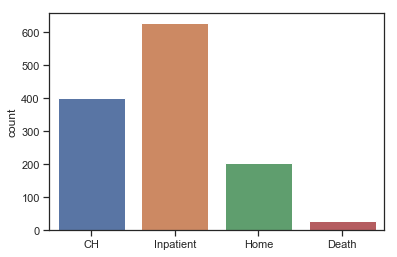

Confusion matrix, without normalization
[[ 17  43  32  14]
 [  4 426 137  20]
 [  3 146 208  21]
 [  3  13  24 149]]


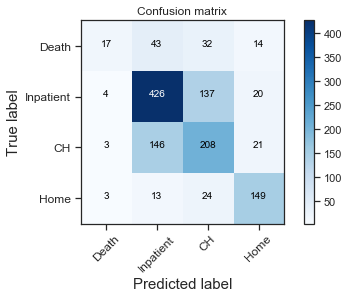

In [100]:
X = df_train['Age'].values.reshape(-1,1)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
collated_scores['Age + MRS'] = scores['test_accuracy']

# NIHSS and MRS

{'fit_time': array([0.14644504, 0.13501215, 0.44096398, 0.31274295, 0.30750799,
       0.15531611, 0.11962509, 0.14624691, 0.15199685, 0.12635422]),
 'score_time': array([0.03365827, 0.03101897, 0.04263115, 0.09001994, 0.04007602,
       0.03847504, 0.03007698, 0.03732896, 0.03145909, 0.03175879]),
 'test_accuracy': array([0.66141732, 0.65354331, 0.63779528, 0.69291339, 0.64566929,
       0.64566929, 0.61904762, 0.704     , 0.72580645, 0.64227642]),
 'test_f1_macro': array([0.61361111, 0.61605958, 0.60726862, 0.64025006, 0.58225532,
       0.57273129, 0.58034709, 0.66277995, 0.62541195, 0.53456543]),
 'test_f1_micro': array([0.66141732, 0.65354331, 0.63779528, 0.69291339, 0.64566929,
       0.64566929, 0.61904762, 0.704     , 0.72580645, 0.64227642]),
 'train_accuracy': array([0.7113857 , 0.7113857 , 0.71050309, 0.70697264, 0.71226831,
       0.71050309, 0.71252205, 0.70044053, 0.70246479, 0.71503958]),
 'train_f1_macro': array([0.65976686, 0.66890904, 0.66657595, 0.66217162, 0.6731733

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


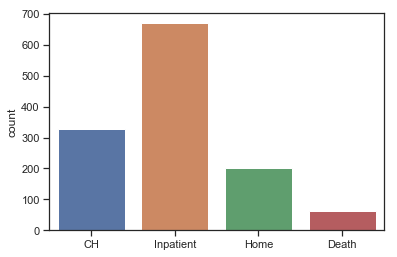

Confusion matrix, without normalization
[[ 37  65   4   0]
 [ 25 461  82  19]
 [  0 138 194  46]
 [  0   6  46 137]]


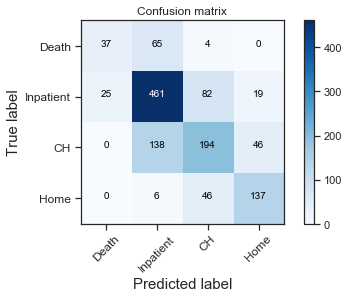

In [101]:
X = df_train['NIHSS'].values.reshape(-1,1)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
collated_scores['MRS + NIHSS'] = scores['test_accuracy']

### And the triple whammy

{'fit_time': array([0.1955688 , 0.23290491, 0.19338083, 0.23446918, 0.13786292,
       0.13781309, 0.13704395, 0.11080408, 0.21572995, 0.13923097]),
 'score_time': array([0.07771015, 0.06264305, 0.04073   , 0.03778887, 0.03969622,
       0.04907084, 0.03417301, 0.03174901, 0.06566405, 0.032125  ]),
 'test_accuracy': array([0.74015748, 0.75590551, 0.72440945, 0.76377953, 0.79527559,
       0.76377953, 0.70634921, 0.784     , 0.78225806, 0.71544715]),
 'test_f1_macro': array([0.72998509, 0.74692027, 0.73340995, 0.71661907, 0.75505963,
       0.70628339, 0.7057742 , 0.74543109, 0.72115701, 0.59737988]),
 'test_f1_micro': array([0.74015748, 0.75590551, 0.72440945, 0.76377953, 0.79527559,
       0.76377953, 0.70634921, 0.784     , 0.78225806, 0.71544715]),
 'train_accuracy': array([0.82524272, 0.81465137, 0.82347749, 0.81288614, 0.81023831,
       0.82877317, 0.82627866, 0.82026432, 0.82482394, 0.82585752]),
 'train_f1_macro': array([0.80504887, 0.78504302, 0.79572714, 0.79150641, 0.7863965

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


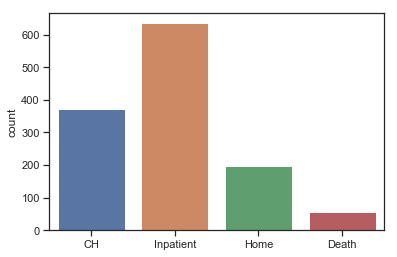

Confusion matrix, without normalization
[[ 40  63   2   1]
 [ 15 473  88  11]
 [  1  95 255  27]
 [  0   4  26 159]]


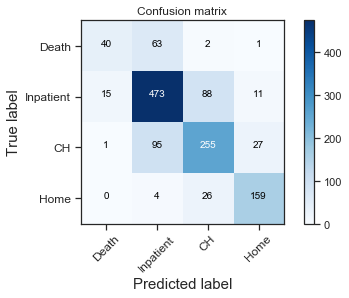

In [102]:
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
scores = run_model(X)
[f"{k} {np.mean(v)}" for k,v in scores.items()]

collated_scores['MRS + NIHSS + Age'] = scores['test_accuracy']


# Add gender

{'fit_time': array([0.16780901, 0.12614918, 0.18743491, 0.12951922, 0.12886667,
       0.16968203, 0.19104576, 0.15808105, 0.12612891, 0.14047098]),
 'score_time': array([0.02839518, 0.04093575, 0.03169894, 0.02530599, 0.03274608,
       0.04083705, 0.03985   , 0.03359294, 0.02609706, 0.03872204]),
 'test_accuracy': array([0.70866142, 0.73228346, 0.71653543, 0.77165354, 0.75590551,
       0.74015748, 0.73015873, 0.752     , 0.75      , 0.71544715]),
 'test_f1_macro': array([0.71093055, 0.67426154, 0.69647076, 0.72760455, 0.72878437,
       0.68916324, 0.72462282, 0.70865839, 0.67485181, 0.62280853]),
 'test_f1_micro': array([0.70866142, 0.73228346, 0.71653543, 0.77165354, 0.75590551,
       0.74015748, 0.73015873, 0.752     , 0.75      , 0.71544715]),
 'train_accuracy': array([0.81641659, 0.81376876, 0.82171227, 0.81376876, 0.81906443,
       0.80759047, 0.82716049, 0.81057269, 0.80545775, 0.823219  ]),
 'train_f1_macro': array([0.78504092, 0.77381774, 0.79263203, 0.7906223 , 0.7942388

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


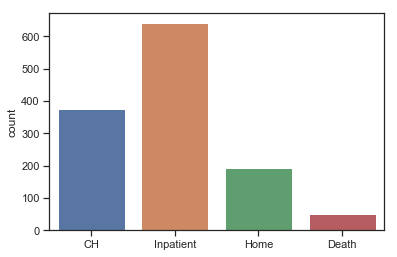

Confusion matrix, without normalization
[[ 40  61   4   1]
 [ 10 467  99  11]
 [  1 109 243  25]
 [  0   4  29 156]]


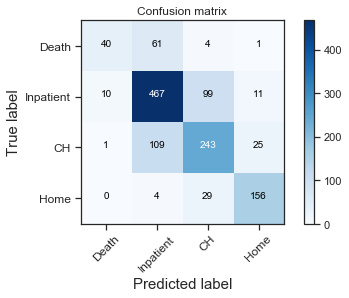

In [103]:
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values, pd.get_dummies(df_train['Gender']).values), axis=1)
scores = run_model(X)
[f"{k} {np.mean(v)}" for k,v in scores.items()]

collated_scores['MRS + NIHSS + Age + Gender'] = scores['test_accuracy']



## Effect of using multiple predictors

In [104]:
collated_scores.keys()

dict_keys(['dummy', 'MRS', 'NIHSS', 'Age', 'Age + NIHSS', 'Age + MRS', 'MRS + NIHSS', 'MRS + NIHSS + Age', 'MRS + NIHSS + Age + Gender'])

In [105]:
collated_scores.keys()

dict_keys(['dummy', 'MRS', 'NIHSS', 'Age', 'Age + NIHSS', 'Age + MRS', 'MRS + NIHSS', 'MRS + NIHSS + Age', 'MRS + NIHSS + Age + Gender'])

In [106]:
model_map = {'dummy':0,
            'MRS':1, 
             'NIHSS':1, 
             'Age':1,
             'Age + NIHSS':2,
            'Age + MRS':2,
            'MRS + NIHSS':2,
            'MRS + NIHSS + Age':3,
            'MRS + NIHSS + Age + Gender':4}

In [107]:
df_test.MRS.value_counts()

4    37
3    34
2    33
0    22
1    17
Name: MRS, dtype: int64

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(1260, 8)
Normalized confusion matrix
[[0.58333333 0.41666667 0.         0.        ]
 [0.07575758 0.74242424 0.15151515 0.03030303]
 [0.         0.18604651 0.79069767 0.02325581]
 [0.04545455 0.13636364 0.09090909 0.72727273]]


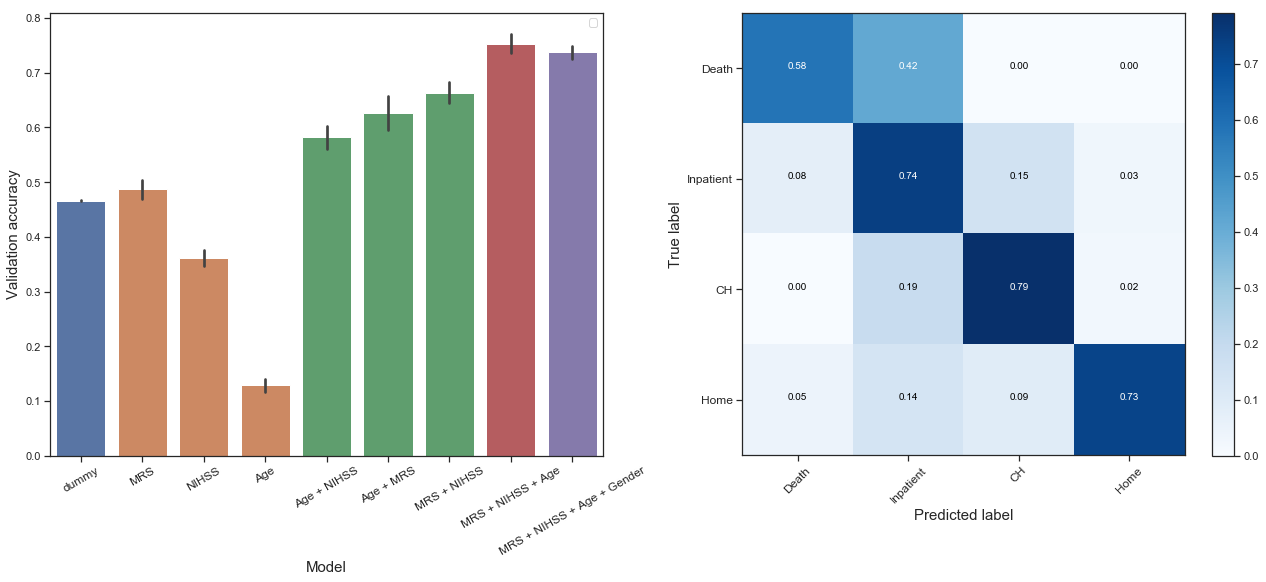

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(full_figure_width, figure_height))


flat = []
for key, value in collated_scores.items():
    for item in value:
        flat.append({key:item})
performance = pd.DataFrame.from_records(flat)
performance['model'] = performance.apply(lambda x: x.idxmax(axis=1), axis=1)
performance['test-accuracy'] = performance.apply(lambda x: x[collated_scores.keys()].max(), axis=1)
performance['number-of-variables'] = performance.model.map(model_map)
performance = performance[['model', 'test-accuracy', 'number-of-variables']]
b = sns.barplot(x='model', y='test-accuracy', hue='number-of-variables', data=performance, dodge=False,
               ax=axes[0])
plt.sca(axes[0])
plt.legend([],[])
plt.ylabel('Validation accuracy',fontsize=_xlabel_size)
plt.xlabel('Model', fontsize=_ylabel_size)
b.set_xticklabels(performance.model.unique(), rotation=30, fontsize=int(_xlabel_size*0.8))


X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)
print(X.shape)
best_rf.fit(X, y)

X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X_test = df_test[['NIHSS', 'Age']].values.reshape(-1,2)

X_test = (X_test - X.mean(axis=0)) / X.std(axis=0)

# have to add a zero column because there are no MRS=5 examples
X_test = np.concatenate((X_test, pd.get_dummies(df_test['MRS']).values, np.zeros((X_test.shape[0], 1))), axis=1)

y_pred = best_rf.predict(X_test)
y_test = df_test['Outcome'].map({v:k for k,v in outcome_dict.items()}).values


plt.sca(axes[1])
confusion_mtx = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion_mtx, classes=outcome_dict.values(), normalize=True)
plt.title('')
plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

plt.show()

test_accuracy = best_rf.score(X_test, y_test)
test_accuracy = best_rf.score(X_test, y_test)

with open('figures/fig3.png', 'wb') as fileout:
     fig.savefig(fileout, bbox_inches='tight')



In [109]:
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

results_dict = dict()
for i, outcome in outcome_dict.items():
    results_dict[outcome] = dict()
    results_dict[outcome]['precision'] = precision[i]
    results_dict[outcome]['recall'] = recall[i]
    results_dict[outcome]['f1'] = f1[i]

In [110]:
results_dict

{'Death': {'precision': 0.5384615384615384,
  'recall': 0.5833333333333334,
  'f1': 0.5599999999999999},
 'Inpatient': {'precision': 0.7538461538461538,
  'recall': 0.7424242424242424,
  'f1': 0.7480916030534351},
 'CH': {'precision': 0.7391304347826086,
  'recall': 0.7906976744186046,
  'f1': 0.7640449438202247},
 'Home': {'precision': 0.8421052631578947,
  'recall': 0.7272727272727273,
  'f1': 0.7804878048780488}}

In [907]:
sum((y_test[y_test==0]==y_pred[y_test==0]))

5

In [900]:
np.sqrt(sum(y_test==0)/np.pi)*2
np.sqrt(sum(y_test==1)/np.pi)*2
np.sqrt(sum(y_test==2)/np.pi)*2
np.sqrt(sum(y_test==3)/np.pi)*2

4.787307364817192

In [911]:
np.sqrt(sum(y_pred==3)/np.pi)*2


4.918490759365935

In [912]:
def circle(radius, centre, point):
    return (point[0]-centre[0])**2 + (point[1]-centre[1])**2 < radius 
    

In [913]:
circle(5, (0,0), (0,1))

True

In [936]:
np.random.random(5)

array([0.14438261, 0.3634067 , 0.7452937 , 0.40508808, 0.2217086 ])

In [987]:
points = 10*np.random.random(10000).reshape(-1, 2)
overlap = dict()
for offset in np.arange(0, 5, 0.01):
    inside_a = np.array([circle(2, (5, 5), point) for point in points])
    inside_b = np.array([circle(4, (5+offset, 5), point) for point in points])
    
    overlap[offset] = sum(inside_a[inside_b==True])

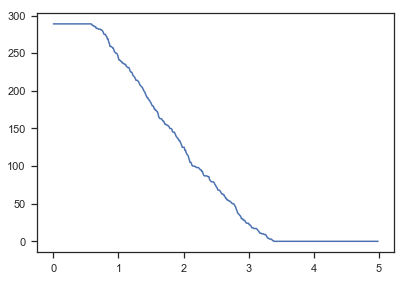

In [988]:
plt.plot(overlap.keys(), overlap.values())

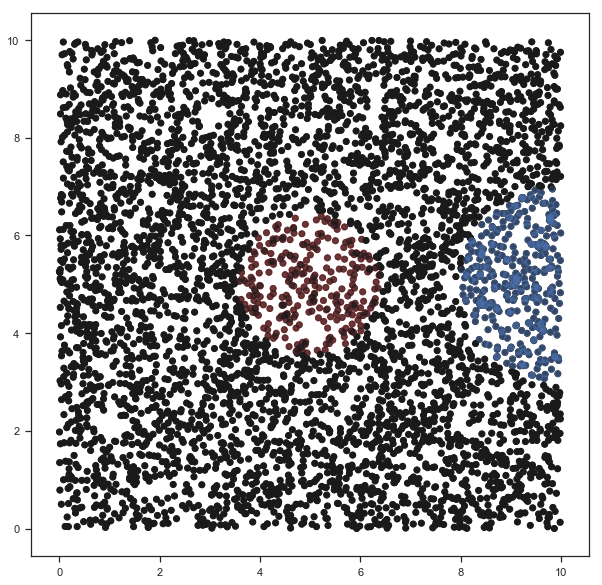

In [990]:
plt.figure(figsize=(10,10))
ax = plt.scatter(points[:,0], points[:,1], color=['r' if i else 'k' for i in inside_a])
ax = plt.scatter(points[:,0], points[:,1], color=['b' if i else 'k' for i in inside_b], alpha=.5)


### Stats on effects of multiple predictors

Effect of model, p=2.0194128383503108e-32 from Kruskal Wallace


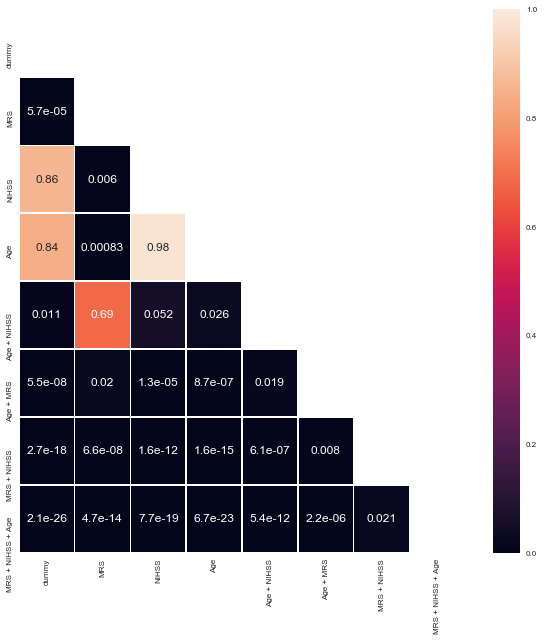

In [860]:

F, p = stats.kruskal(*collated_scores.values())

print(f"Effect of model, p={p} from Kruskal Wallace")

p_mtx = np.zeros((len(collated_scores), len(collated_scores))) 
for i, model1 in enumerate(collated_scores.keys()):
    for j, model2 in enumerate(collated_scores.keys()):
         _ , p_mtx[i, j]= stats.ttest_ind(collated_scores[model1],
           collated_scores[model2])

mask = np.zeros_like(p_mtx)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(p_mtx, xticklabels=collated_scores.keys(), yticklabels=collated_scores.keys(), mask=mask, annot=True, linewidths=.5)

plt.show()
    
    

In [ ]:
b.figure

In [510]:
b.

[]

In [60]:
from sklearn.preprocessing import PolynomialFeatures

In [63]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

score_dict = {}
for c in np.linspace(0.01, 5, 15):
    lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight=None, max_iter=1000, C=c)
    scores = run_model(X, lm=lm)

    score_dict[c] = {k :np.mean(v) for k,v in scores.items()}

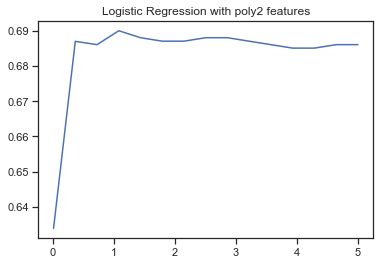

In [65]:
plt.title('Logistic Regression with poly2 features')
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

In [67]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)


score_dict = {}
for c in np.linspace(0.01, 5, 15):

    lm = LogisticRegression(multi_class='multinomial', solver='saga', class_weight=None, max_iter=1000, C=c)
    scores = run_model(X, lm=lm)

    score_dict[c] = {k :np.mean(v) for k,v in scores.items()}


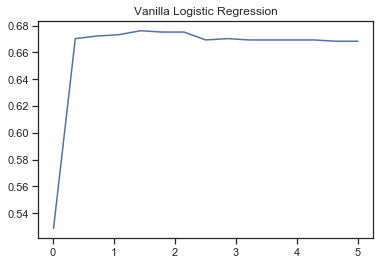

In [68]:
plt.title('Vanilla Logistic Regression')
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

## Simple model for visualization

In [365]:
X = df_train[['NIHSS', 'Age']]

train_mean = X.mean()
train_std = X.std()
X = X.apply(lambda x: (x - train_mean)/train_std, axis=1).values.reshape(-1,2)

X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

#poly = PolynomialFeatures(interaction_only=True)
#X = poly.fit_transform(X)

lm = LogisticRegression(multi_class='multinomial', solver='saga', fit_intercept=False)
lm.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [366]:
params = ['NIHSS', 'Age', 'M0', 'M1', 'M2', 'M3', 'M4', 'M5']

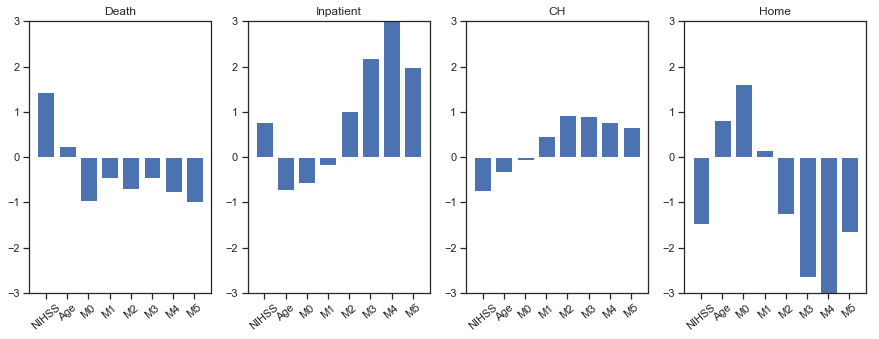

In [367]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.bar(range(lm.coef_.shape[1]), lm.coef_[i])
    plt.ylim((-3, 3))
    plt.title(outcome_dict[i])
    plt.xticks(range(len(params)), params, rotation=40)

In [368]:
params = np.append(lm.intercept_[-1],lm.coef_[-1])
predictions = lm.predict(X)

newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

myDF3 = pd.DataFrame()
myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilites"] = [params,sd_b,ts_b,p_values]
print(myDF3)

   Coefficients  Standard Errors  t values  Probabilites
0        0.0000      3111510.751     0.000           1.0
1       -1.4837            0.020   -75.932           0.0
2        0.8088            0.023    35.843           0.0
3        1.6040      3111510.751     0.000           1.0
4        0.1575      3111510.751     0.000           1.0
5       -1.2526      3111510.751    -0.000           1.0
6       -2.6403      3111510.751    -0.000           1.0
7       -3.1398      3111510.751    -0.000           1.0
8       -1.6511      3111510.751    -0.000           1.0


In [372]:
from ipywidgets import interactive

def normalize(item, mean, std):
    return np.asarray((item-mean) / std).reshape(1, -1)

def one_hot_mrs(mrs):
    z = np.zeros(6)
    z[mrs] = 1
    return z

def unconditional_graphs(age, nihss, mrs, probs):
       
    plt.figure(figsize=(15,3))
    plt.subplot(141)
    sns.distplot(df['Age'],rug=True)
    plt.axvline(age, color='r')
    
    plt.subplot(142)
    sns.distplot(df['NIHSS'], rug=True)
    plt.axvline(nihss, color='r')
    
    plt.subplot(143)
    sns.distplot(df['MRS'], kde=False, bins=range(7))
    plt.axvline(mrs, color='r')
    
    plt.subplot(144)

    ax = plt.bar(np.arange(len(probs.reshape(-1,))), probs.reshape(-1,).tolist(), linewidth=.2)
    plt.xticks(np.arange(len(probs.reshape(-1,))), outcome_dict.values())
    plt.ylim([0, 1])
    plt.title('Predictions')


def plot_predictions_model_unconditional(age, nihss, mrs):
    example = np.concatenate([normalize(nihss, train_mean[0] ,train_std[0]),
              normalize(age, train_mean[1] ,train_std[1]),
              one_hot_mrs(mrs).reshape(1, -1)
              ],
             axis=1)
  
    probs = lm.predict_proba(example)
    unconditional_graphs(age, nihss, mrs, probs)

interactive_plot = interactive(plot_predictions_model, age=(0, 100, 2), nihss=(0, 35, 1), mrs=(0, 5, 1))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=50, description='age', step=2), IntSlider(value=17, description='nihss',…

## Conditional version

In [407]:
def plot_predictions_model_conditional(age, nihss, mrs):
    example = np.concatenate([normalize(nihss, train_mean[0] ,train_std[0]),
              normalize(age, train_mean[1] ,train_std[1]),
              one_hot_mrs(mrs).reshape(1, -1)
              ],
             axis=1)
  
    probs = lm.predict_proba(example)
    conditional_graphs(age, nihss, mrs, probs)
    
def conditional_graphs(age, nihss, mrs, probs):
    g = sns.FacetGrid(df, col="MRS",  hue='Outcome', legend_out=True)
    g.map(sns.scatterplot, "Age", 'NIHSS', alpha=.5)
    g.add_legend()
    
    plt.sca(g.axes[0][mrs])

    plt.axvline(age, color='r')
    plt.axhline(nihss, color='r')
    plt.show()
    
    plt.figure(figsize=(5,5))
    ax = plt.bar(np.arange(len(probs.reshape(-1,))), probs.reshape(-1,).tolist(), linewidth=.2)
    plt.xticks(np.arange(len(probs.reshape(-1,))), outcome_dict.values())
    plt.ylim([0, 1])
    plt.title('Predictions')

In [466]:
import joblib
joblib.dump(lm, 'logistic_regression.model')


['logistic_regression.model']

In [471]:
type(train_mean)

pandas.core.series.Series

In [472]:
train_mean

NIHSS     8.137795
Age      73.759843
dtype: float64

In [473]:
train_std

NIHSS     7.223710
Age      14.157503
dtype: float64

In [408]:
interactive_plot = interactive(plot_predictions_model_conditional, age=(0, 100, 2), nihss=(0, 35, 1), mrs=(0, 5, 1))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(IntSlider(value=50, description='age', step=2), IntSlider(value=17, description='nihss',…

# TO DO
- [ ] Conditional visualization
- [x] Probability density estimates for NIHSS/MRS
- [ ] MLP
- [ ] Webapp
- [ ] Random forest

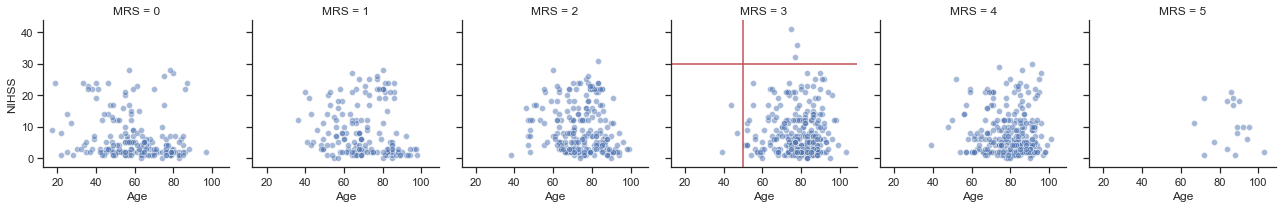

In [391]:
age = 50
nihss = 30
mrs = 3



## KNN

In [413]:
from sklearn.neighbors import KNeighborsClassifier

In [414]:
nbrs = KNeighborsClassifier(n_neighbors=5, algorithm='ball_tree')

{'fit_time': array([0.00111318, 0.00089407, 0.00066781, 0.000844  , 0.0005331 ]),
 'score_time': array([0.0121448 , 0.00870585, 0.01044202, 0.00783515, 0.00862217]),
 'test_accuracy': array([0.70098039, 0.65686275, 0.64215686, 0.66009852, 0.6119403 ]),
 'test_f1_macro': array([0.64710426, 0.62431108, 0.60105931, 0.60732751, 0.56986859]),
 'test_f1_micro': array([0.70098039, 0.65686275, 0.64215686, 0.66009852, 0.6119403 ]),
 'train_accuracy': array([0.74876847, 0.73891626, 0.75492611, 0.75768758, 0.75214724]),
 'train_f1_macro': array([0.71776393, 0.7012623 , 0.71648944, 0.72183648, 0.72525339]),
 'train_f1_micro': array([0.74876847, 0.73891626, 0.75492611, 0.75768758, 0.75214724])}


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


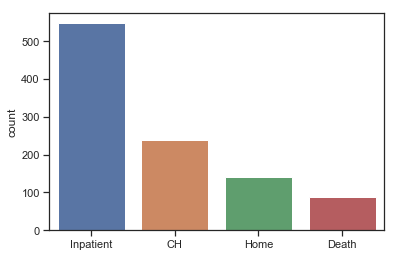

Confusion matrix, without normalization
[[ 44  48   3   0]
 [ 34 379  75  11]
 [ 10 105 136  18]
 [  0  16  24 113]]


/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_accuracy'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1_macro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_f1_micro'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_a

{'fit_time': array([0.00111318, 0.00089407, 0.00066781, 0.000844  , 0.0005331 ]),
 'score_time': array([0.0121448 , 0.00870585, 0.01044202, 0.00783515, 0.00862217]),
 'test_accuracy': array([0.70098039, 0.65686275, 0.64215686, 0.66009852, 0.6119403 ]),
 'train_accuracy': array([0.74876847, 0.73891626, 0.75492611, 0.75768758, 0.75214724]),
 'test_f1_macro': array([0.64710426, 0.62431108, 0.60105931, 0.60732751, 0.56986859]),
 'train_f1_macro': array([0.71776393, 0.7012623 , 0.71648944, 0.72183648, 0.72525339]),
 'test_f1_micro': array([0.70098039, 0.65686275, 0.64215686, 0.66009852, 0.6119403 ]),
 'train_f1_micro': array([0.74876847, 0.73891626, 0.75492611, 0.75768758, 0.75214724])}

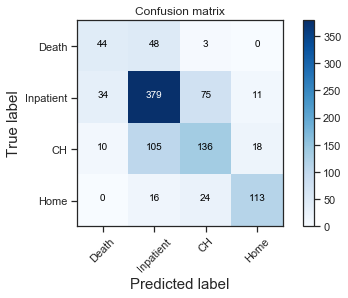

In [415]:
run_model(X, lm=nbrs)

In [433]:
%%capture
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(X)

score_dict = {}
for n in np.arange(1, 30):
    nbrs = KNeighborsClassifier(n_neighbors=n, algorithm='ball_tree')
    scores = run_model(X, lm=nbrs)

    score_dict[n] = {k :np.mean(v) for k,v in scores.items()}

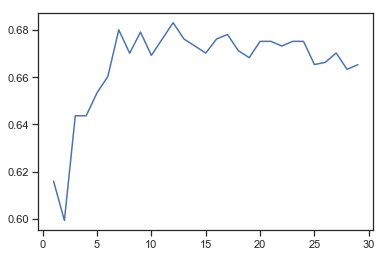

In [434]:
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

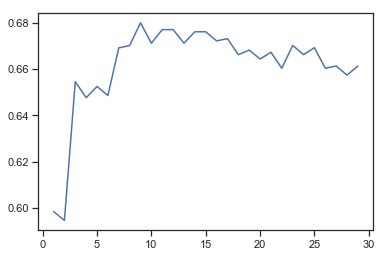

In [430]:
plt.plot(score_dict.keys(), [v['test_accuracy'] for v in score_dict.values()])

In [425]:
np.mean(X, axis=0)

array([6.91157542e-17, 1.49732589e-16, 1.62401575e-01, 1.41732283e-01,
       1.95866142e-01, 2.47047244e-01, 2.36220472e-01, 1.67322835e-02])

## Random forest

In [536]:
%%capture
from sklearn.ensemble import RandomForestClassifier
max_d= 12
max_s = 8

X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

acc = np.zeros((max_d, max_s))

for d in range(5, max_d):
    for s in range(2, max_s):
        rf = RandomForestClassifier(n_estimators=100, max_depth=d, min_samples_split=s)
        scores = run_model(X, rf=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

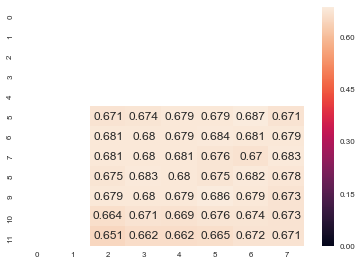

In [537]:
sns.heatmap(acc, annot=True, mask=acc==0, fmt='.3g')

{'fit_time': array([0.17204475, 0.1204989 , 0.12374592, 0.12559199, 0.09874511,
       0.09409595, 0.09434485, 0.12058067, 0.11580968, 0.09106374]),
 'score_time': array([0.042032  , 0.02143431, 0.03188515, 0.02774811, 0.02214599,
       0.02586412, 0.03178406, 0.02737308, 0.02607322, 0.0209341 ]),
 'test_accuracy': array([0.73786408, 0.6407767 , 0.65048544, 0.75490196, 0.6372549 ,
       0.73267327, 0.69306931, 0.65346535, 0.68316832, 0.64646465]),
 'test_f1_macro': array([0.71137566, 0.54014122, 0.60703698, 0.75033337, 0.56153976,
       0.67016535, 0.61648249, 0.55014157, 0.64765274, 0.61539084]),
 'test_f1_micro': array([0.73786408, 0.6407767 , 0.65048544, 0.75490196, 0.6372549 ,
       0.73267327, 0.69306931, 0.65346535, 0.68316832, 0.64646465]),
 'train_accuracy': array([0.7864184 , 0.7864184 , 0.78094195, 0.76805252, 0.77899344,
       0.78251366, 0.79672131, 0.78688525, 0.78251366, 0.78953108]),
 'train_f1_macro': array([0.75634646, 0.74131773, 0.75290688, 0.7085833 , 0.746127 

/Users/archy/anaconda/envs/stroke-discharge/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


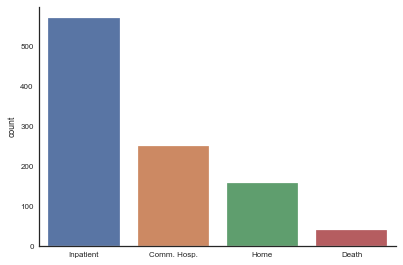

Confusion matrix, without normalization
[[ 31  60   3   1]
 [  7 408  70  14]
 [  1  93 151  24]
 [  0   8  26 119]]
0.6830123960425739


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

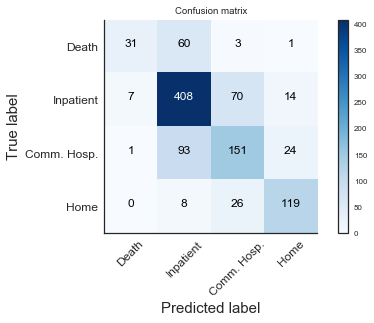

In [700]:
X = df_train[['NIHSS', 'Age']].values.reshape(-1,2)
X = stats.zscore(X)
X = np.concatenate((X, pd.get_dummies(df_train['MRS']).values), axis=1)

best_rf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_split=3)
scores = run_model(X, rf=best_rf)
score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
print(score_dict[d,s]['test_accuracy'])

best_rf.fit(X, y)

### Use MRS as a continuous input

In [58]:
%%capture
from sklearn.ensemble import RandomForestClassifier
max_d= 20
max_s = 20

X = df_train[['NIHSS', 'Age', 'MRS']].values.reshape(-1,3)
X = stats.zscore(X)

acc = np.zeros((max_d, max_s))

for d in range(2, max_d):
    for s in range(2, max_s):
        rf = RandomForestClassifier(n_estimators=100, max_depth=d, min_samples_split=s)
        scores = run_model(X, rf=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

NameError: name 'run_model' is not defined

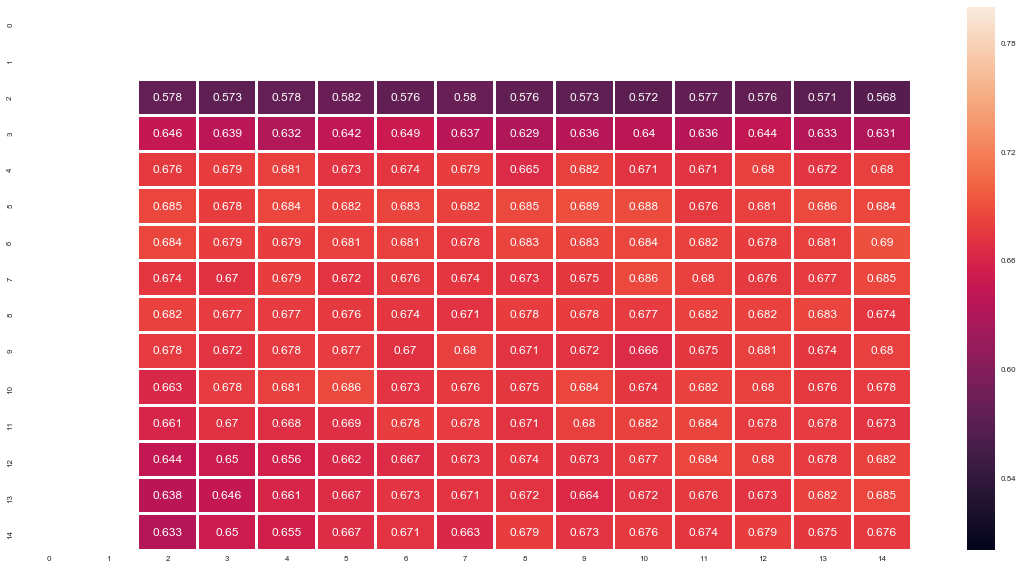

In [550]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(acc, annot=True, mask=acc==0, fmt='0.3g', ax=ax, linewidths=2, vmin=0.5, vmax=0.8)

## Gradient Boosted

In [71]:
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
%%capture
max_d= 6
max_s = 6
acc = np.zeros((max_d, max_s))

for d in range(3, max_d):
    for s in range(3, max_s):
        rf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=d, min_samples_split=s)
        scores = run_model(X, lm=rf)
        score_dict[d,s] = {k :np.mean(v) for k,v in scores.items()}
        acc[d, s] = score_dict[d,s]['test_accuracy']

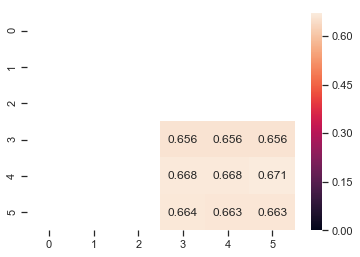

In [75]:
sns.heatmap(acc, annot=True, mask=acc==0, fmt='.3g')

# Modelling summary
- Logistic regression gives you about 0.68
- Nearest neighbour roughly the same, a fraction worse
- Adding polynomial features gives you 0.69
- Random forest gets you to about 0.70

## Explaining the model
- [ ] Permutation importances
- [ ] Partial dependence plots
- [ ] Sample decision trees
- [ ] Per-example explanation

Working with the random forest model:

### 1. Permutation importances

In [85]:
feature_names = ['NIHSS', 'Age', 'MRS0','MRS1','MRS2','MRS3','MRS4','MRS5']

In [91]:
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(best_rf).fit(X, y)
eli5.explain_weights(perm, target_names=outcome_dict, feature_names=feature_names, targets=outcome_dict.keys())

Weight,Feature
0.2337 ± 0.0318,NIHSS
0.1531 ± 0.0230,Age
0.1280 ± 0.0196,MRS0
0.0776 ± 0.0096,MRS4
0.0756 ± 0.0097,MRS1
0.0244 ± 0.0071,MRS2
0.0230 ± 0.0048,MRS3
0.0010 ± 0.0012,MRS5


In [190]:
from eli5 import explain_weights
from eli5 import formatters
obj = explain_weights(best_rf, feature_names=feature_names)
expl_df = formatters.format_as_dataframe(obj)

In [996]:
expl_df

,feature,weight,std
0,NIHSS,0.352112,0.040541
1,Age,0.308006,0.046314
2,MRS0,0.106066,0.053757
3,MRS4,0.101018,0.050080
4,MRS1,0.061248,0.036078
5,MRS3,0.040513,0.033932
6,MRS2,0.025973,0.021391
7,MRS5,0.005063,0.005567


In [995]:
expl_df.iloc[2:]['weight'].sum()

0.3398818329393075

In [784]:
df_train.iloc[3]

Age        49
NIHSS       4
MRS         0
Outcome    CH
Name: 1000, dtype: object

In [785]:
X[3,:]

array([-0.57308964, -1.74974621,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [704]:
best_rf.predict_proba(X[3,:].reshape(1, -1))

array([[0.00179088, 0.10495041, 0.53795993, 0.35529877]])

In [713]:
def plot_explanation_for_prediction(model, x, feature_names=feature_names, ax=None):
    explanation = explain_prediction(best_rf, x,feature_names=feature_names)
    expl = formatters.as_dataframe.format_as_dataframe(explanation)

    expl = expl.sort_values('feature')
    expl.rename({'feature':'Feature', 'weight':'Weight', 'outcome':'Outcome'}, inplace=True, axis=1)

    expl['Outcome'] = expl['target'].map(outcome_dict)
    expl['include'] = expl['value'] != 0
    
    g = sns.catplot(x="Feature", y="Weight", hue="Outcome", data=expl.loc[expl.include & (expl.Feature.str.contains('<BIAS>') == False)],
                height=6, kind="bar", ax=ax, hue_order=order)


In [783]:
X[3,:]

array([-0.57308964, -1.74974621,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [782]:
explanation = explain_prediction(best_rf, X[3,:],feature_names=feature_names)
expl = formatters.as_dataframe.format_as_dataframe(explanation)
expl

,target,feature,weight,value
0,0,<BIAS>,0.093524,1.000000
1,0,MRS4,0.005453,0.000000
2,0,MRS5,0.000157,0.000000
3,0,MRS3,-0.000272,0.000000
4,0,MRS2,-0.001981,0.000000
5,0,MRS1,-0.004469,0.000000
6,0,MRS0,-0.015585,1.000000
7,0,Age,-0.015900,-1.749746
8,0,NIHSS,-0.059136,-0.573090
9,1,<BIAS>,0.492559,1.000000


In [772]:
def plot_prediction(model, x_input, ax=None):
    _pred = model.predict_proba(x_input.reshape(1, -1))
    df_prediction = pd.DataFrame(_pred.T*100, index=pd.Index(outcome_dict.values()), columns=['Probability'])
    df_prediction['Outcome']= df_prediction.index
    sns.catplot(data=df_prediction, x='Outcome', y='Probability', order=order, kind='bar', ax=ax)

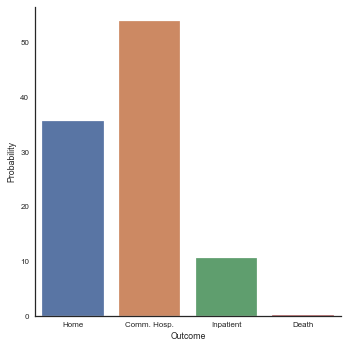

In [773]:
plot_prediction(best_rf, X[3,:])

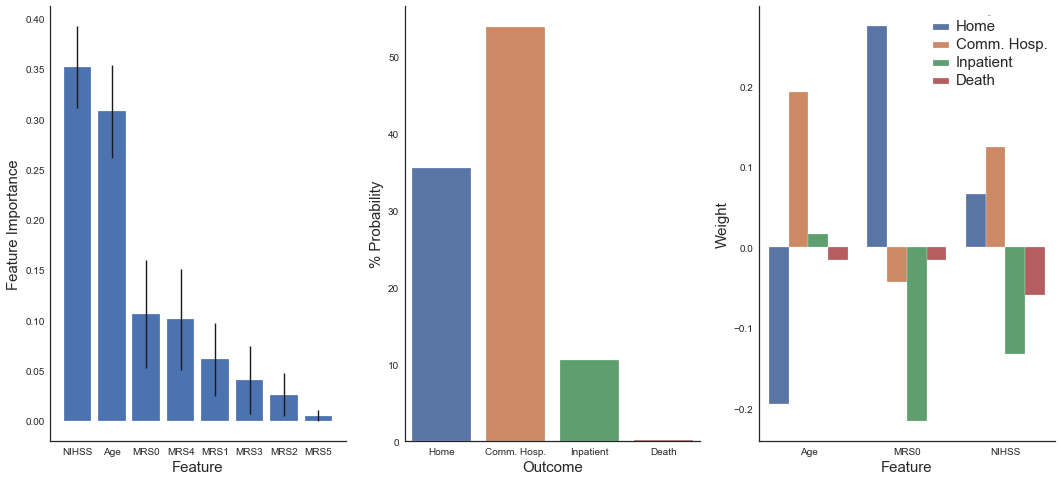

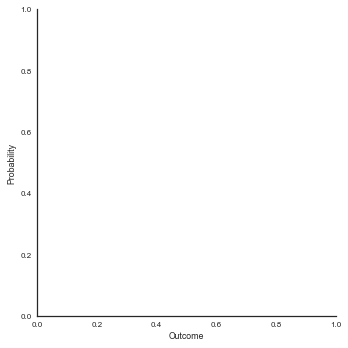

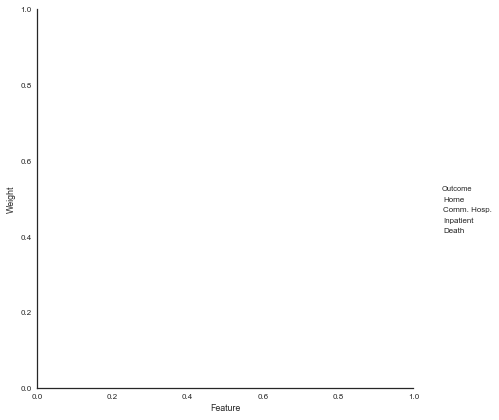

In [774]:
sns.set_style(_plot_style)
fig, axes = plt.subplots(ncols=3, figsize=(full_figure_width, figure_height))
plt.sca(axes[0])
plt.bar(range(len(expl_df)), expl_df['weight'].values)
plt.errorbar(range(len(expl_df)), expl_df['weight'].values, expl_df['std'].values,  fmt=' ', color='k')
plt.xticks(range(len(expl_df)), expl_df.feature)
plt.xlabel('Feature', fontsize=_xlabel_size)
plt.ylabel('Feature Importance', fontsize=_ylabel_size)
plt.tick_params(axis='both', which='major', labelsize=10)


plot_prediction(best_rf, X[3,:], ax=axes[1])
plt.sca(axes[1])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Outcome', fontsize=_xlabel_size)
plt.ylabel('% Probability', fontsize=_ylabel_size)

plot_explanation_for_prediction(best_rf, X[3,:], ax=axes[-1])
plt.sca(axes[-1])
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Feature', fontsize=_xlabel_size)
plt.ylabel('Weight', fontsize=_ylabel_size)

plt.setp(axes[2].get_legend().get_texts(), fontsize='15') # for legend text
plt.setp(axes[2].get_legend().get_title(), fontsize='0') # for legend title

sns.despine()

plt.show()

with open('figures/fig5.png', 'wb') as fileout:
    fig.savefig(fileout, bbox_inches='tight')



    

,feature,weight,std
0,NIHSS,0.352112,0.040541
1,Age,0.308006,0.046314
2,MRS0,0.106066,0.053757
3,MRS4,0.101018,0.050080
4,MRS1,0.061248,0.036078
5,MRS3,0.040513,0.033932
6,MRS2,0.025973,0.021391
7,MRS5,0.005063,0.005567


### 2. Partial Dependence Plots

Difficult to achieve this for the case of 3 dimensions with 4 output classes. I think a 3 x 4 subplot may be necessary?

In [99]:
x_min = X.min(axis=0)
x_max = X.max(axis=0)

In [117]:
all_probabilities = np.zeros((10,10,6,4))

In [118]:
for i_n, _nihss in enumerate(np.linspace(x_min[0], x_max[0], 10)):
    for i_a, _age in enumerate(np.linspace(x_min[1], x_max[1], 10)):
        for _mrs in range(0, 6):
            mrs_dummies = np.zeros((6))
            mrs_dummies[_mrs] = 1
            
            input = np.concatenate((np.array([_nihss, _age]).reshape(1,-1), mrs_dummies.reshape(1,-1)), axis=1)
            prediction = best_rf.predict_proba(input)
            
            all_probabilities[i_n, i_a, _mrs, :] = prediction

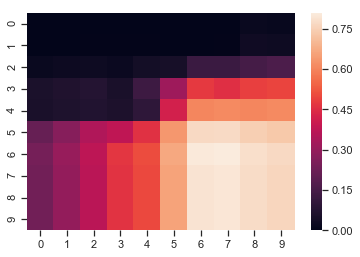

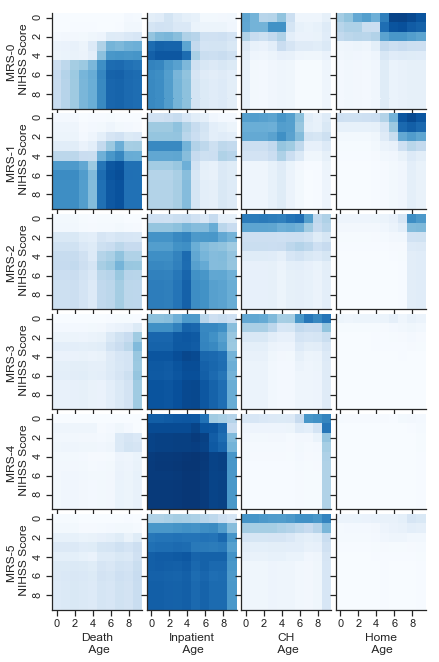

In [160]:
g = sns.FacetGrid(df, row="MRS", col="Outcome", margin_titles=True, height=1.5)

for _outcome in range(0,4):
    for _mrs in range(0, 6):
        plt.sca(g.axes[_mrs, _outcome])
        sns.heatmap(all_probabilities[:,:,_mrs,_outcome], cbar=False, vmin=0, vmax=1, cmap="Blues")
        sns.despine()
        
for i in range(0,4):
    g.axes[-1,i].set_xlabel(outcome_dict[i] + '\n Age')

for i in range(0,6):
    g.axes[i,0].set_ylabel("MRS-%d \n NIHSS Score"%i)

g.fig.subplots_adjust(wspace=.05, hspace=.05)

### 4. Per-prediction explanation

In [578]:
from eli5 import show_prediction, explain_prediction
show_prediction(best_rf, X[0,:],show_feature_values=True, feature_names=feature_names)

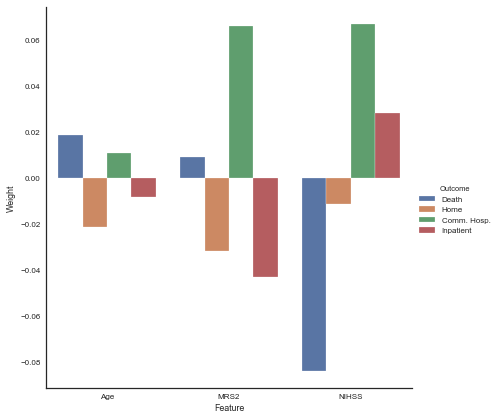

In [672]:
plot_explanation_for_prediction(best_rf, X[2,:])